<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 48

# Student 1: Joëlle Bink

# Student 2: Tom Groot

# Student 3: Rick Stolk

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

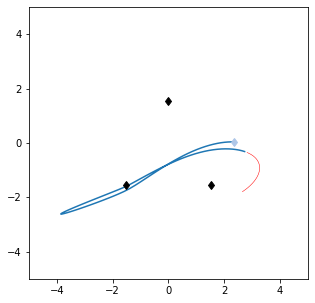

Charges are [-0.89030568 -0.6475334  -0.03630237]


In [7]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [121]:
#Input will be the simulation data with the positions of particle p1. Label will be the charges c2, c3 and c4.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [122]:
# We transform the simulation to be of the shortest length
def transform_data(original_simulations, original_charges):
    shortest = 999999999999999999
    data = []
    for i in range(len(original_simulations)):
        if (len(original_simulations[i]) < shortest):
            shortest = len(original_simulations[i])
    for i in range(len(original_simulations)):
        data.append(original_simulations[i][:shortest])
    data = torch.from_numpy(np.array(data))
    charges = torch.from_numpy(np.array(original_charges))
    return data, charges

In [123]:
data_train, charge_labels_train = transform_data(simulation_train, charges_train)
data_valid, charge_labels_valid = transform_data(simulation_valid, charges_valid)
data_test, charge_labels_test = transform_data(simulation_test, charges_test)

In [124]:
from torch.utils.data import Dataset, DataLoader,TensorDataset
class MyDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        x = self.data[index].float()
        target = self.labels[index].float()
        if torch.cuda.is_available():
            x, target = x.cuda(), target.cuda()
        
        return x, target

    def __len__(self):
        return len(self.data)

In [125]:
dataset_train = MyDataset(data_train, charge_labels_train)
dataset_valid = MyDataset(data_valid, charge_labels_valid)
dataset_test = MyDataset(data_test, charge_labels_test)

## Model Implementation

In [263]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("CPU used")

class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, batch_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_dim, batch_first=True)
        self.batch = nn.BatchNorm1d(90)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x, batch_size=0):
        hidden = self.init_hidden(len(x[0]), batch_size=batch_size)
        out, hidden = self.lstm(x, hidden)
        out = self.batch(out)
        out = self.fc(out)
        return out[:, -1, :]
    
    def init_hidden(self, size, batch_size = 0):
        if batch_size == 0:
            batch_size = self.batch_size 
        hidden = (torch.randn(1, batch_size, self.hidden_dim).to(device),
          torch.randn(1, batch_size, self.hidden_dim).to(device))
        return hidden

GPU available


## Model Training

In [553]:
"""
Calculates the accuracy by testing every charge in the simulation.
If every charge within a simulation is within a certain threshold (0.1), we count the simulation correct. 
"""
def calculate_accuracy(model, dataset, limit=100):
    total = 0
    correct = 0
    threshold = 0.1
    for i in range(0, len(dataset)):
        if i > limit and limit != 0:
            break
        x, target = dataset.__getitem__(i)
        pred = model(x.unsqueeze(0), batch_size=1)[0]
        total += 1
        for i in range(len(pred)):
            if (pred[i] > target[i] + threshold or pred[i] < target[i] - threshold):
                break;
            if len(pred) - 1 == i:    
                correct += 1
    print(f"Accuracy over all simulations: {correct/total}")
    return correct/total
    
"""
Accuracy calculated by number of charges that lie within a certain threshold (0.1), 
regardless if the rest of the charges in the same simulation are correct. 
"""
def all_charges_accuracy(model, dataset, limit=100):
    total = 0
    correct = 0
    threshold = 0.1
    for i in range(0, len(dataset)):
        if i > limit and limit != 0:
            break
        x, target = dataset.__getitem__(i)
        pred = model(x.unsqueeze(0), batch_size=1)[0]
        for i in range(len(pred)):
            total += 1         
            if (pred[i] < target[i] + threshold and pred[i] > target[i] - threshold):
                correct += 1
    print(f"Accuracy over all charges: {correct/total}")
    return correct/total

In [562]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, TensorDataset
import math

batch_size = 10
model = Model(input_size=2, output_size=3, hidden_dim=100, batch_size=batch_size)
model = model.to(device)

# For possibly loading a trained model
# model.load_state_dict(torch.load('./model_withforward_31'))

# Hyperparameters
n_epochs = 70
lr=0.01

loader = DataLoader(dataset_train, batch_size=batch_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metrics = {
    'valid_all_acc': [],
    'valid_acc': [],
    'train_all_acc': [],
    'train_acc': [],
    'loss': []
}

for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0
    for i, (x, target) in enumerate(tqdm(loader)):
        optimizer.zero_grad()
        pred = model(x)      
        the_loss = criterion(pred, target)
        total_loss += the_loss.item()
        the_loss.backward()
        optimizer.step()
    
    # Print validation data     
    model.eval()
    print(f"Epoch [{epoch}/{n_epochs}] Training loss: {total_loss/len(dataset_train):.4f}")
    print("Validation dataset")
    metrics['loss'].append(total_loss/len(dataset_train))
    metrics['valid_acc'].append(calculate_accuracy(model, dataset_valid))
    metrics['valid_all_acc'].append(all_charges_accuracy(model, dataset_valid))
    metrics['train_acc'].append(calculate_accuracy(model, dataset_train))
    metrics['train_all_acc'].append(all_charges_accuracy(model, dataset_train))


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 77.98it/s]


Epoch [1/70] Training loss: 0.0143
Validation dataset
Accuracy over all simulations: 0.01
Accuracy over all charges: 0.19
Accuracy over all simulations: 0.019801980198019802
Accuracy over all charges: 0.2607260726072607


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 87.75it/s]


Epoch [2/70] Training loss: 0.0084
Validation dataset
Accuracy over all simulations: 0.01
Accuracy over all charges: 0.18
Accuracy over all simulations: 0.009900990099009901
Accuracy over all charges: 0.2508250825082508


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 86.42it/s]


Epoch [3/70] Training loss: 0.0084
Validation dataset
Accuracy over all simulations: 0.02
Accuracy over all charges: 0.21333333333333335
Accuracy over all simulations: 0.019801980198019802
Accuracy over all charges: 0.2838283828382838


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 87.31it/s]


Epoch [4/70] Training loss: 0.0093
Validation dataset
Accuracy over all simulations: 0.0
Accuracy over all charges: 0.21
Accuracy over all simulations: 0.019801980198019802
Accuracy over all charges: 0.1848184818481848


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 76.54it/s]


Epoch [5/70] Training loss: 0.0073
Validation dataset
Accuracy over all simulations: 0.01
Accuracy over all charges: 0.3333333333333333
Accuracy over all simulations: 0.019801980198019802
Accuracy over all charges: 0.26732673267326734


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 78.72it/s]


Epoch [6/70] Training loss: 0.0054
Validation dataset
Accuracy over all simulations: 0.02
Accuracy over all charges: 0.32666666666666666
Accuracy over all simulations: 0.009900990099009901
Accuracy over all charges: 0.30033003300330036


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 80.82it/s]


Epoch [7/70] Training loss: 0.0051
Validation dataset
Accuracy over all simulations: 0.04
Accuracy over all charges: 0.32666666666666666
Accuracy over all simulations: 0.0297029702970297
Accuracy over all charges: 0.38613861386138615


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 86.73it/s]


Epoch [8/70] Training loss: 0.0044
Validation dataset
Accuracy over all simulations: 0.09
Accuracy over all charges: 0.4033333333333333
Accuracy over all simulations: 0.039603960396039604
Accuracy over all charges: 0.40924092409240925


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 73.94it/s]


Epoch [9/70] Training loss: 0.0039
Validation dataset
Accuracy over all simulations: 0.06
Accuracy over all charges: 0.4166666666666667
Accuracy over all simulations: 0.04950495049504951
Accuracy over all charges: 0.39933993399339934


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 73.23it/s]


Epoch [10/70] Training loss: 0.0035
Validation dataset
Accuracy over all simulations: 0.06
Accuracy over all charges: 0.4166666666666667
Accuracy over all simulations: 0.0594059405940594
Accuracy over all charges: 0.37623762376237624


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 63.77it/s]


Epoch [11/70] Training loss: 0.0039
Validation dataset
Accuracy over all simulations: 0.08
Accuracy over all charges: 0.35
Accuracy over all simulations: 0.0594059405940594
Accuracy over all charges: 0.4389438943894389


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 86.72it/s]


Epoch [12/70] Training loss: 0.0033
Validation dataset
Accuracy over all simulations: 0.14
Accuracy over all charges: 0.41333333333333333
Accuracy over all simulations: 0.06930693069306931
Accuracy over all charges: 0.44554455445544555


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 86.08it/s]


Epoch [13/70] Training loss: 0.0033
Validation dataset
Accuracy over all simulations: 0.07
Accuracy over all charges: 0.39666666666666667
Accuracy over all simulations: 0.10891089108910891
Accuracy over all charges: 0.40924092409240925


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 87.31it/s]


Epoch [14/70] Training loss: 0.0035
Validation dataset
Accuracy over all simulations: 0.05
Accuracy over all charges: 0.42
Accuracy over all simulations: 0.039603960396039604
Accuracy over all charges: 0.39603960396039606


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 71.20it/s]


Epoch [15/70] Training loss: 0.0030
Validation dataset
Accuracy over all simulations: 0.11
Accuracy over all charges: 0.46
Accuracy over all simulations: 0.12871287128712872
Accuracy over all charges: 0.49174917491749176


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 72.39it/s]


Epoch [16/70] Training loss: 0.0038
Validation dataset
Accuracy over all simulations: 0.08
Accuracy over all charges: 0.39666666666666667
Accuracy over all simulations: 0.06930693069306931
Accuracy over all charges: 0.42574257425742573


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 84.32it/s]


Epoch [17/70] Training loss: 0.0030
Validation dataset
Accuracy over all simulations: 0.14
Accuracy over all charges: 0.4266666666666667
Accuracy over all simulations: 0.09900990099009901
Accuracy over all charges: 0.5082508250825083


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 68.08it/s]


Epoch [18/70] Training loss: 0.0034
Validation dataset
Accuracy over all simulations: 0.13
Accuracy over all charges: 0.4033333333333333
Accuracy over all simulations: 0.15841584158415842
Accuracy over all charges: 0.44554455445544555


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 84.82it/s]


Epoch [19/70] Training loss: 0.0032
Validation dataset
Accuracy over all simulations: 0.08
Accuracy over all charges: 0.35333333333333333
Accuracy over all simulations: 0.04950495049504951
Accuracy over all charges: 0.42244224422442245


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 89.29it/s]


Epoch [20/70] Training loss: 0.0035
Validation dataset
Accuracy over all simulations: 0.04
Accuracy over all charges: 0.3333333333333333
Accuracy over all simulations: 0.039603960396039604
Accuracy over all charges: 0.36303630363036304


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 83.67it/s]


Epoch [21/70] Training loss: 0.0033
Validation dataset
Accuracy over all simulations: 0.17
Accuracy over all charges: 0.5033333333333333
Accuracy over all simulations: 0.09900990099009901
Accuracy over all charges: 0.4752475247524752


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 87.69it/s]


Epoch [22/70] Training loss: 0.0026
Validation dataset
Accuracy over all simulations: 0.17
Accuracy over all charges: 0.48333333333333334
Accuracy over all simulations: 0.0891089108910891
Accuracy over all charges: 0.48184818481848185


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 70.67it/s]


Epoch [23/70] Training loss: 0.0024
Validation dataset
Accuracy over all simulations: 0.12
Accuracy over all charges: 0.5233333333333333
Accuracy over all simulations: 0.18811881188118812
Accuracy over all charges: 0.5148514851485149


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 70.67it/s]


Epoch [24/70] Training loss: 0.0021
Validation dataset
Accuracy over all simulations: 0.14
Accuracy over all charges: 0.5033333333333333
Accuracy over all simulations: 0.22772277227722773
Accuracy over all charges: 0.5676567656765676


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 86.89it/s]


Epoch [25/70] Training loss: 0.0022
Validation dataset
Accuracy over all simulations: 0.22
Accuracy over all charges: 0.5133333333333333
Accuracy over all simulations: 0.1485148514851485
Accuracy over all charges: 0.5379537953795379


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 87.77it/s]


Epoch [26/70] Training loss: 0.0023
Validation dataset
Accuracy over all simulations: 0.06
Accuracy over all charges: 0.42333333333333334
Accuracy over all simulations: 0.0891089108910891
Accuracy over all charges: 0.44884488448844884


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 87.40it/s]


Epoch [27/70] Training loss: 0.0024
Validation dataset
Accuracy over all simulations: 0.18
Accuracy over all charges: 0.49666666666666665
Accuracy over all simulations: 0.21782178217821782
Accuracy over all charges: 0.5841584158415841


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 87.55it/s]


Epoch [28/70] Training loss: 0.0018
Validation dataset
Accuracy over all simulations: 0.18
Accuracy over all charges: 0.5333333333333333
Accuracy over all simulations: 0.21782178217821782
Accuracy over all charges: 0.6138613861386139


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 83.63it/s]


Epoch [29/70] Training loss: 0.0018
Validation dataset
Accuracy over all simulations: 0.18
Accuracy over all charges: 0.5133333333333333
Accuracy over all simulations: 0.1485148514851485
Accuracy over all charges: 0.49834983498349833


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 86.83it/s]


Epoch [30/70] Training loss: 0.0017
Validation dataset
Accuracy over all simulations: 0.23
Accuracy over all charges: 0.5666666666666667
Accuracy over all simulations: 0.2376237623762376
Accuracy over all charges: 0.6138613861386139


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 63.37it/s]


Epoch [31/70] Training loss: 0.0015
Validation dataset
Accuracy over all simulations: 0.2
Accuracy over all charges: 0.5833333333333334
Accuracy over all simulations: 0.297029702970297
Accuracy over all charges: 0.6534653465346535


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 73.94it/s]


Epoch [32/70] Training loss: 0.0015
Validation dataset
Accuracy over all simulations: 0.25
Accuracy over all charges: 0.59
Accuracy over all simulations: 0.2079207920792079
Accuracy over all charges: 0.6270627062706271


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 66.08it/s]


Epoch [33/70] Training loss: 0.0015
Validation dataset
Accuracy over all simulations: 0.21
Accuracy over all charges: 0.5966666666666667
Accuracy over all simulations: 0.25742574257425743
Accuracy over all charges: 0.6600660066006601


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 80.14it/s]


Epoch [34/70] Training loss: 0.0013
Validation dataset
Accuracy over all simulations: 0.25
Accuracy over all charges: 0.6033333333333334
Accuracy over all simulations: 0.3564356435643564
Accuracy over all charges: 0.6798679867986799


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 84.95it/s]


Epoch [35/70] Training loss: 0.0014
Validation dataset
Accuracy over all simulations: 0.21
Accuracy over all charges: 0.5933333333333334
Accuracy over all simulations: 0.297029702970297
Accuracy over all charges: 0.6567656765676567


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 84.45it/s]


Epoch [36/70] Training loss: 0.0014
Validation dataset
Accuracy over all simulations: 0.29
Accuracy over all charges: 0.65
Accuracy over all simulations: 0.31683168316831684
Accuracy over all charges: 0.6798679867986799


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 87.94it/s]


Epoch [37/70] Training loss: 0.0012
Validation dataset
Accuracy over all simulations: 0.25
Accuracy over all charges: 0.61
Accuracy over all simulations: 0.37623762376237624
Accuracy over all charges: 0.6666666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 84.01it/s]


Epoch [38/70] Training loss: 0.0011
Validation dataset
Accuracy over all simulations: 0.31
Accuracy over all charges: 0.65
Accuracy over all simulations: 0.4158415841584158
Accuracy over all charges: 0.7557755775577558


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 82.93it/s]


Epoch [39/70] Training loss: 0.0010
Validation dataset
Accuracy over all simulations: 0.32
Accuracy over all charges: 0.65
Accuracy over all simulations: 0.39603960396039606
Accuracy over all charges: 0.7227722772277227


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 82.48it/s]


Epoch [40/70] Training loss: 0.0010
Validation dataset
Accuracy over all simulations: 0.26
Accuracy over all charges: 0.62
Accuracy over all simulations: 0.3564356435643564
Accuracy over all charges: 0.7161716171617162


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 64.16it/s]


Epoch [41/70] Training loss: 0.0009
Validation dataset
Accuracy over all simulations: 0.35
Accuracy over all charges: 0.69
Accuracy over all simulations: 0.5148514851485149
Accuracy over all charges: 0.759075907590759


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 86.29it/s]


Epoch [42/70] Training loss: 0.0011
Validation dataset
Accuracy over all simulations: 0.29
Accuracy over all charges: 0.5866666666666667
Accuracy over all simulations: 0.31683168316831684
Accuracy over all charges: 0.6996699669966997


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 84.98it/s]


Epoch [43/70] Training loss: 0.0011
Validation dataset
Accuracy over all simulations: 0.37
Accuracy over all charges: 0.6866666666666666
Accuracy over all simulations: 0.44554455445544555
Accuracy over all charges: 0.7557755775577558


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 87.03it/s]


Epoch [44/70] Training loss: 0.0012
Validation dataset
Accuracy over all simulations: 0.33
Accuracy over all charges: 0.67
Accuracy over all simulations: 0.42574257425742573
Accuracy over all charges: 0.7161716171617162


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 90.01it/s]


Epoch [45/70] Training loss: 0.0011
Validation dataset
Accuracy over all simulations: 0.41
Accuracy over all charges: 0.68
Accuracy over all simulations: 0.43564356435643564
Accuracy over all charges: 0.7227722772277227


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 74.64it/s]


Epoch [46/70] Training loss: 0.0012
Validation dataset
Accuracy over all simulations: 0.32
Accuracy over all charges: 0.6766666666666666
Accuracy over all simulations: 0.39603960396039606
Accuracy over all charges: 0.735973597359736


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 77.44it/s]


Epoch [47/70] Training loss: 0.0009
Validation dataset
Accuracy over all simulations: 0.36
Accuracy over all charges: 0.6633333333333333
Accuracy over all simulations: 0.45544554455445546
Accuracy over all charges: 0.7722772277227723


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 88.61it/s]


Epoch [48/70] Training loss: 0.0009
Validation dataset
Accuracy over all simulations: 0.35
Accuracy over all charges: 0.6966666666666667
Accuracy over all simulations: 0.46534653465346537
Accuracy over all charges: 0.7887788778877888


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 84.44it/s]


Epoch [49/70] Training loss: 0.0008
Validation dataset
Accuracy over all simulations: 0.16
Accuracy over all charges: 0.5633333333333334
Accuracy over all simulations: 0.27722772277227725
Accuracy over all charges: 0.6138613861386139


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 85.47it/s]


Epoch [50/70] Training loss: 0.0013
Validation dataset
Accuracy over all simulations: 0.29
Accuracy over all charges: 0.6366666666666667
Accuracy over all simulations: 0.25742574257425743
Accuracy over all charges: 0.6204620462046204


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 81.76it/s]


Epoch [51/70] Training loss: 0.0011
Validation dataset
Accuracy over all simulations: 0.33
Accuracy over all charges: 0.6866666666666666
Accuracy over all simulations: 0.40594059405940597
Accuracy over all charges: 0.7194719471947195


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 81.79it/s]


Epoch [52/70] Training loss: 0.0009
Validation dataset
Accuracy over all simulations: 0.37
Accuracy over all charges: 0.71
Accuracy over all simulations: 0.5346534653465347
Accuracy over all charges: 0.7887788778877888


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 73.77it/s]


Epoch [53/70] Training loss: 0.0008
Validation dataset
Accuracy over all simulations: 0.37
Accuracy over all charges: 0.7033333333333334
Accuracy over all simulations: 0.49504950495049505
Accuracy over all charges: 0.768976897689769


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 66.81it/s]


Epoch [54/70] Training loss: 0.0007
Validation dataset
Accuracy over all simulations: 0.39
Accuracy over all charges: 0.72
Accuracy over all simulations: 0.5346534653465347
Accuracy over all charges: 0.8184818481848185


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 89.07it/s]


Epoch [55/70] Training loss: 0.0007
Validation dataset
Accuracy over all simulations: 0.33
Accuracy over all charges: 0.6666666666666666
Accuracy over all simulations: 0.46534653465346537
Accuracy over all charges: 0.7887788778877888


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 85.55it/s]


Epoch [56/70] Training loss: 0.0006
Validation dataset
Accuracy over all simulations: 0.43
Accuracy over all charges: 0.7066666666666667
Accuracy over all simulations: 0.6831683168316832
Accuracy over all charges: 0.858085808580858


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 89.41it/s]


Epoch [57/70] Training loss: 0.0005
Validation dataset
Accuracy over all simulations: 0.43
Accuracy over all charges: 0.7466666666666667
Accuracy over all simulations: 0.6435643564356436
Accuracy over all charges: 0.8646864686468647


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 85.89it/s]


Epoch [58/70] Training loss: 0.0006
Validation dataset
Accuracy over all simulations: 0.34
Accuracy over all charges: 0.7233333333333334
Accuracy over all simulations: 0.48514851485148514
Accuracy over all charges: 0.8118811881188119


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 86.68it/s]


Epoch [59/70] Training loss: 0.0008
Validation dataset
Accuracy over all simulations: 0.43
Accuracy over all charges: 0.74
Accuracy over all simulations: 0.48514851485148514
Accuracy over all charges: 0.7953795379537953


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 88.43it/s]


Epoch [60/70] Training loss: 0.0006
Validation dataset
Accuracy over all simulations: 0.6
Accuracy over all charges: 0.7866666666666666
Accuracy over all simulations: 0.6336633663366337
Accuracy over all charges: 0.8646864686468647


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 86.73it/s]


Epoch [61/70] Training loss: 0.0006
Validation dataset
Accuracy over all simulations: 0.42
Accuracy over all charges: 0.7033333333333334
Accuracy over all simulations: 0.5643564356435643
Accuracy over all charges: 0.8184818481848185


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 85.84it/s]


Epoch [62/70] Training loss: 0.0005
Validation dataset
Accuracy over all simulations: 0.38
Accuracy over all charges: 0.73
Accuracy over all simulations: 0.5643564356435643
Accuracy over all charges: 0.8481848184818482


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 81.17it/s]


Epoch [63/70] Training loss: 0.0012
Validation dataset
Accuracy over all simulations: 0.25
Accuracy over all charges: 0.5666666666666667
Accuracy over all simulations: 0.3069306930693069
Accuracy over all charges: 0.6468646864686468


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 87.89it/s]


Epoch [64/70] Training loss: 0.0014
Validation dataset
Accuracy over all simulations: 0.28
Accuracy over all charges: 0.6866666666666666
Accuracy over all simulations: 0.32673267326732675
Accuracy over all charges: 0.6897689768976898


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 88.63it/s]


Epoch [65/70] Training loss: 0.0010
Validation dataset
Accuracy over all simulations: 0.34
Accuracy over all charges: 0.7133333333333334
Accuracy over all simulations: 0.4158415841584158
Accuracy over all charges: 0.7458745874587459


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 84.12it/s]


Epoch [66/70] Training loss: 0.0007
Validation dataset
Accuracy over all simulations: 0.37
Accuracy over all charges: 0.7133333333333334
Accuracy over all simulations: 0.5148514851485149
Accuracy over all charges: 0.7953795379537953


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 88.41it/s]


Epoch [67/70] Training loss: 0.0005
Validation dataset
Accuracy over all simulations: 0.4
Accuracy over all charges: 0.7166666666666667
Accuracy over all simulations: 0.594059405940594
Accuracy over all charges: 0.8415841584158416


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 89.16it/s]


Epoch [68/70] Training loss: 0.0005
Validation dataset
Accuracy over all simulations: 0.43
Accuracy over all charges: 0.7433333333333333
Accuracy over all simulations: 0.6534653465346535
Accuracy over all charges: 0.8250825082508251


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 82.68it/s]


Epoch [69/70] Training loss: 0.0005
Validation dataset
Accuracy over all simulations: 0.43
Accuracy over all charges: 0.7266666666666667
Accuracy over all simulations: 0.5643564356435643
Accuracy over all charges: 0.8316831683168316


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 82.47it/s]


Epoch [70/70] Training loss: 0.0005
Validation dataset
Accuracy over all simulations: 0.58
Accuracy over all charges: 0.7733333333333333
Accuracy over all simulations: 0.7128712871287128
Accuracy over all charges: 0.858085808580858


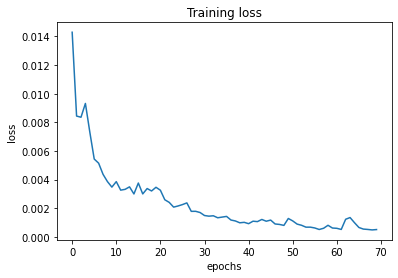

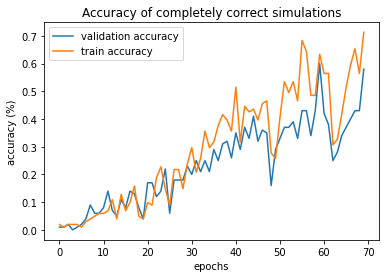

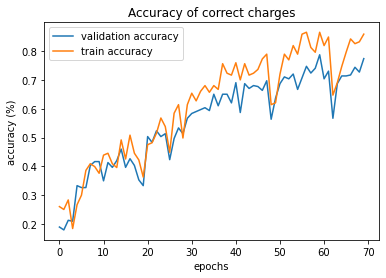

In [576]:
# Loss
fig = plt.figure()
axes = plt.gca()
cmap = matplotlib.cm.get_cmap('tab20')
plt.title("Training loss")
plt.plot(metrics['loss'], color=cmap(0))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Accuracy
fig = plt.figure()
axes = plt.gca()
cmap = matplotlib.cm.get_cmap('tab20')
plt.title("Accuracy of completely correct simulations")
plt.plot(metrics['valid_acc'])
plt.plot(metrics['train_acc'])
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(["validation accuracy", "train accuracy"])
plt.show()

# All charges accuracy
fig = plt.figure()
axes = plt.gca()
cmap = matplotlib.cm.get_cmap('tab20')
plt.title("Accuracy of correct charges")
plt.plot(metrics['valid_all_acc'])
plt.plot(metrics['train_all_acc'])
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(["validation accuracy", "train accuracy"])
plt.show()


In [577]:
# For saving the model
# torch.save(model.state_dict(), './model_withforward_31')

## Evaluation

In [287]:
print("Accuracy test dataset")
calculate_accuracy(model, dataset_test, 0)
all_charges_accuracy(model, dataset_test, 0)

Accuracy test dataset
Accuracy over all simulations: 0.6
Accuracy over all charges: 0.8266666666666667


# Task 3.2

## Data Handling and Preprocessing

In [135]:
# Splits data into data (the known path), continues (the path from the continued simulation)
# and totals (data and continues combined)
def transform_data_32(original_simulations, original_continues):
    shortest_d = 999999999999999999
    data = []
    for i in range(len(original_simulations)):
        if (len(original_simulations[i]) < shortest_d):
            shortest_d = len(original_simulations[i])
    shortest = 999999999999999999
    continues = []
    totals = []
    for i in range(len(original_continues)):
        if (len(original_continues[i]) < shortest):
            shortest = len(original_continues[i])
    
    
    for i in range(len(original_simulations)):
        offset = len(original_simulations[i]) - shortest_d
        total = np.append(original_simulations[i][offset:], original_continues[i][:shortest], axis=0)
        continues.append(original_continues[i][:shortest])
        data.append(original_simulations[i][offset:])
        totals.append(total)
    data = torch.from_numpy(np.array(data))
    continues = torch.from_numpy(np.array(continues))
    totals = torch.from_numpy(np.array(totals))
  
    return data, continues, totals

In [140]:
data_train_path, data_train_continued, train_totals = transform_data_32(simulation_train_task32, simulation_continued_train)
data_valid_path, data_valid_continued, valid_totals = transform_data_32(simulation_valid, simulation_continued_valid)
data_test_path, data_test_continued, test_totals = transform_data_32(simulation_test, simulation_continued_test)

In [336]:
class MyDataset32(Dataset):
    def __init__(self, data, labels, totals):
        super().__init__()
        self.data = data
        self.labels = labels
        self.totals = totals

    def __getitem__(self, index):
        x = self.data[index].float()
        target = self.labels[index].float()
        total = self.totals[index].float()
        if torch.cuda.is_available():
            x, target, total = x.cuda(), target.cuda(), total.cuda()
        
        return x, target, total

    def __len__(self):
        return len(self.data)

In [337]:
dataset_train_path = MyDataset32(data_train_path, data_train_continued, train_totals)
dataset_valid_path = MyDataset32(data_valid_path, data_valid_continued, valid_totals)
dataset_test_path = MyDataset32(data_test_path, data_test_continued, test_totals)

## Model Implementation

In [341]:
"""
Very similar to the model in 3.1. 
Altough, this model has a different output size and reshapes the output to match the output_size.
"""
class Model32(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, batch_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_dim, batch_first=True)
        self.batch = nn.BatchNorm1d(90)
        self.fc = nn.Linear(hidden_dim, self.output_size[0] * self.output_size[1])
    
    def forward(self, x, batch_size=0):
        hidden = self.init_hidden(len(x[0]), batch_size=batch_size)
        out, hidden = self.lstm(x, hidden)
        out = self.batch(out)
        out = self.fc(out)
        if batch_size == 0:
            batch_size = self.batch_size 
        return out[:, -1, :].reshape(batch_size, self.output_size[0], self.output_size[1])
    
    def init_hidden(self, size, batch_size = 0):
        if batch_size == 0:
            batch_size = self.batch_size 
        hidden = (torch.randn(1, batch_size, self.hidden_dim).to(device),
          torch.randn(1, batch_size, self.hidden_dim).to(device))
        return hidden

## Model Training

In [570]:
def show_progress(dataset, progress_model, index=0):
    # Plot the first item
    x, target, total = dataset.__getitem__(index)
    pred = progress_model(x.unsqueeze(0), 1)[0]
    plot_example(total.cpu().detach().numpy(), target.cpu().detach().numpy(), pred.cpu().detach().numpy())
    
from math import sqrt
def calc_distance(x1, y1, x2, y2):
    dist = sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    return dist

"""
Calculate the accuracy by looping over every point and checking if it is closer to the ground truth than the threshold
"""
def calc_accuracy_all_points_32(model, dataset, limit=100, threshold=0.5):
    model.eval()
    n_total = 0
    correct = 0
    for i, (x, target, total) in enumerate(dataset):
        if i > limit and limit != 0:
            break
        pred = model(x.unsqueeze(0), batch_size=1)[0]
        for i in range(len(pred)):
            n_total += 1     
            if (calc_distance(pred[i][0].item(), pred[i][1].item(), target[i][0].item(), target[i][1].item()) < threshold):
                correct += 1
    print(f"Accuracy over all points in all simulations: {correct/n_total}")
    return correct/n_total
    
def is_simulation_close_enough(model, dataset, index, threshold=0.5):
    x, target, total = dataset.__getitem__(index)
    n_total = 0
    correct = 0
    pred = model(x.unsqueeze(0), batch_size=1)[0]
    for i in range(len(pred)):
        n_total += 1
        if calc_distance(pred[i][0].item(), pred[i][1].item(), target[i][0].item(), target[i][1].item()) < threshold:
            correct += 1

    if n_total == correct:
        return True
    return False

"""
Calculate the accuracy by looping over every simulation and checking if EVERY point in the simulation matches the ground truth
by checking if the points are closer to the ground truth than the threshold
"""
def calc_accuracy_all_simulations_32(model, dataset, limit=100, threshold=0.5):
    n_total = len(dataset)
    correct = 0
    for i in range(len(dataset)):
        if is_simulation_close_enough(model, dataset, i, threshold=threshold):
            correct += 1
            
    print(f"Accuracy over all simulations: {correct/n_total}")
    return correct/n_total
    
        

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 73.88it/s]


Epoch [1/100] Training loss: 0.1503
Accuracy over all points in all simulations: 0.03663366336633663
Show progress of validation dataset


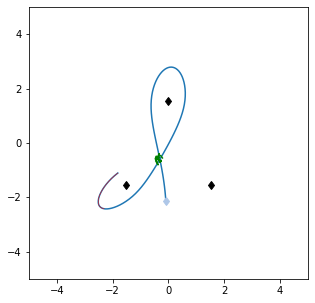

Accuracy over all points in all simulations: 0.0355
Accuracy over all simulations: 0.0
Accuracy over all points in all simulations: 0.0355
Accuracy over all simulations: 0.0
Accuracy over all points in all simulations: 0.035333333333333335


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 54.94it/s]


Epoch [2/100] Training loss: 0.1036
Accuracy over all points in all simulations: 0.05198019801980198
Show progress of validation dataset


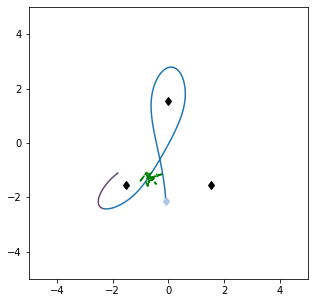

Accuracy over all points in all simulations: 0.048
Accuracy over all simulations: 0.0
Accuracy over all points in all simulations: 0.048
Accuracy over all simulations: 0.0
Accuracy over all points in all simulations: 0.04666666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 77.34it/s]


Epoch [3/100] Training loss: 0.0947
Accuracy over all points in all simulations: 0.09405940594059406
Show progress of validation dataset


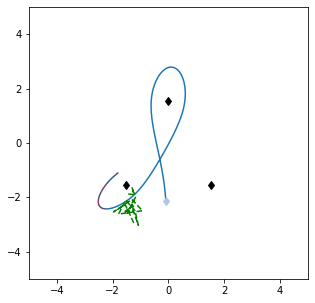

Accuracy over all points in all simulations: 0.092
Accuracy over all simulations: 0.0
Accuracy over all points in all simulations: 0.092
Accuracy over all simulations: 0.0
Accuracy over all points in all simulations: 0.091


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 81.19it/s]


Epoch [4/100] Training loss: 0.0793
Accuracy over all points in all simulations: 0.22326732673267327
Show progress of validation dataset


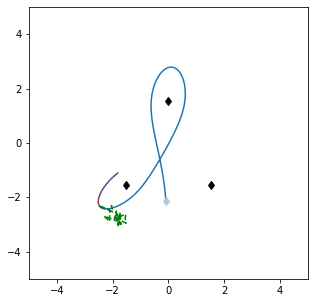

Accuracy over all points in all simulations: 0.2455
Accuracy over all simulations: 0.01
Accuracy over all points in all simulations: 0.2455
Accuracy over all simulations: 0.0
Accuracy over all points in all simulations: 0.214


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.87it/s]


Epoch [5/100] Training loss: 0.0649
Accuracy over all points in all simulations: 0.31584158415841584
Show progress of validation dataset


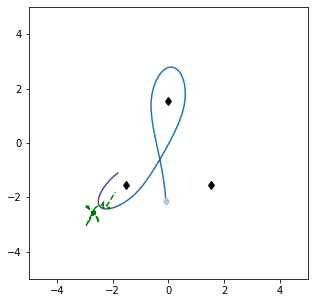

Accuracy over all points in all simulations: 0.3275
Accuracy over all simulations: 0.02
Accuracy over all points in all simulations: 0.3275
Accuracy over all simulations: 0.006666666666666667
Accuracy over all points in all simulations: 0.32066666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 56.82it/s]


Epoch [6/100] Training loss: 0.0503
Accuracy over all points in all simulations: 0.38465346534653466
Show progress of validation dataset


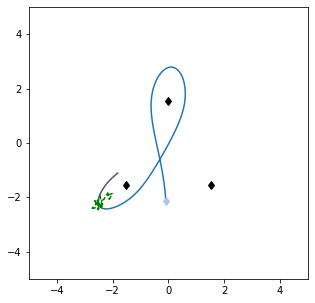

Accuracy over all points in all simulations: 0.4135
Accuracy over all simulations: 0.05
Accuracy over all points in all simulations: 0.4135
Accuracy over all simulations: 0.04666666666666667
Accuracy over all points in all simulations: 0.394


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 62.50it/s]


Epoch [7/100] Training loss: 0.0474
Accuracy over all points in all simulations: 0.404950495049505
Show progress of validation dataset


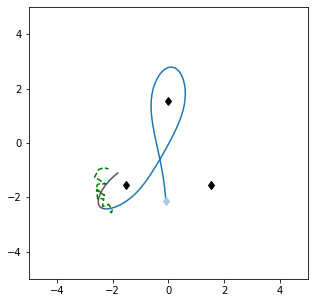

Accuracy over all points in all simulations: 0.3765
Accuracy over all simulations: 0.02
Accuracy over all points in all simulations: 0.3765
Accuracy over all simulations: 0.06
Accuracy over all points in all simulations: 0.419


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 88.16it/s]

Epoch [8/100] Training loss: 0.0513


Accuracy over all points in all simulations: 0.249009900990099
Show progress of validation dataset


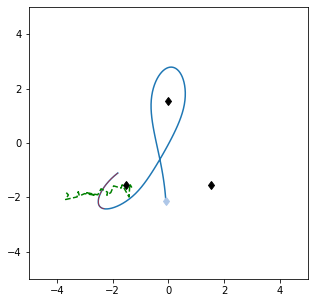

Accuracy over all points in all simulations: 0.225
Accuracy over all simulations: 0.03
Accuracy over all points in all simulations: 0.225
Accuracy over all simulations: 0.02666666666666667
Accuracy over all points in all simulations: 0.27166666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 59.76it/s]


Epoch [9/100] Training loss: 0.0462
Accuracy over all points in all simulations: 0.3435643564356436
Show progress of validation dataset


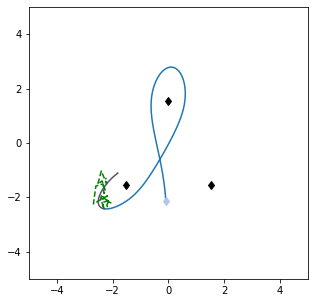

Accuracy over all points in all simulations: 0.3435
Accuracy over all simulations: 0.03
Accuracy over all points in all simulations: 0.3435
Accuracy over all simulations: 0.02
Accuracy over all points in all simulations: 0.34


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.23it/s]


Epoch [10/100] Training loss: 0.0421
Accuracy over all points in all simulations: 0.45841584158415843
Show progress of validation dataset


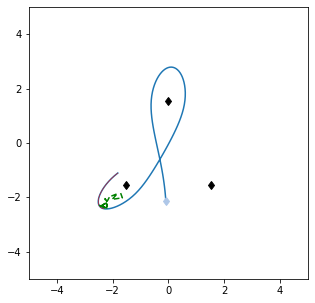

Accuracy over all points in all simulations: 0.42
Accuracy over all simulations: 0.03
Accuracy over all points in all simulations: 0.42
Accuracy over all simulations: 0.02666666666666667
Accuracy over all points in all simulations: 0.467


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.22it/s]


Epoch [11/100] Training loss: 0.0307
Accuracy over all points in all simulations: 0.451980198019802
Show progress of validation dataset


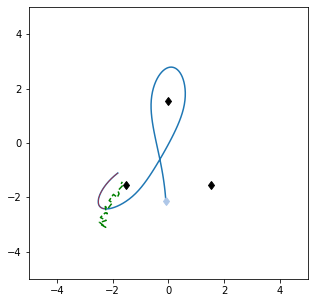

Accuracy over all points in all simulations: 0.4475
Accuracy over all simulations: 0.05
Accuracy over all points in all simulations: 0.4475
Accuracy over all simulations: 0.05333333333333334
Accuracy over all points in all simulations: 0.469


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 92.81it/s]

Epoch [12/100] Training loss: 0.0268


Accuracy over all points in all simulations: 0.5262376237623763
Show progress of validation dataset


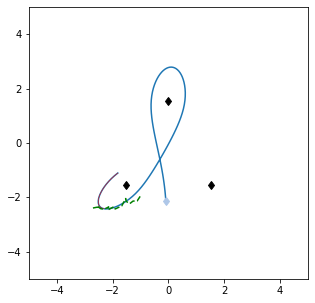

Accuracy over all points in all simulations: 0.5265
Accuracy over all simulations: 0.09
Accuracy over all points in all simulations: 0.5265
Accuracy over all simulations: 0.08
Accuracy over all points in all simulations: 0.559


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 93.73it/s]

Epoch [13/100] Training loss: 0.0256


Accuracy over all points in all simulations: 0.47425742574257423
Show progress of validation dataset


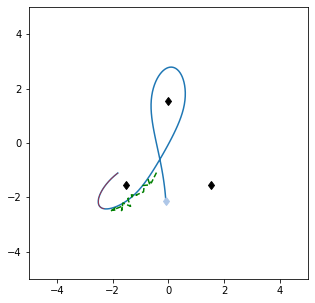

Accuracy over all points in all simulations: 0.473
Accuracy over all simulations: 0.05
Accuracy over all points in all simulations: 0.473
Accuracy over all simulations: 0.08666666666666667
Accuracy over all points in all simulations: 0.5063333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 79.80it/s]


Epoch [14/100] Training loss: 0.0291
Accuracy over all points in all simulations: 0.4212871287128713
Show progress of validation dataset


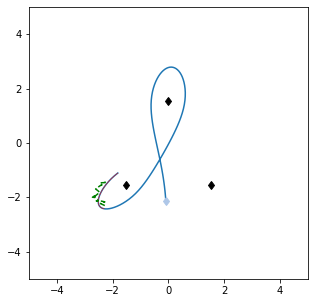

Accuracy over all points in all simulations: 0.4235
Accuracy over all simulations: 0.04
Accuracy over all points in all simulations: 0.4235
Accuracy over all simulations: 0.1
Accuracy over all points in all simulations: 0.456


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 57.03it/s]


Epoch [15/100] Training loss: 0.0328
Accuracy over all points in all simulations: 0.4514851485148515
Show progress of validation dataset


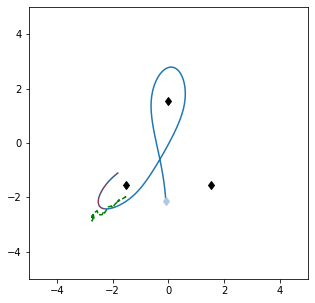

Accuracy over all points in all simulations: 0.437
Accuracy over all simulations: 0.05
Accuracy over all points in all simulations: 0.437
Accuracy over all simulations: 0.11333333333333333
Accuracy over all points in all simulations: 0.4726666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 51.90it/s]


Epoch [16/100] Training loss: 0.0222
Accuracy over all points in all simulations: 0.5168316831683168
Show progress of validation dataset


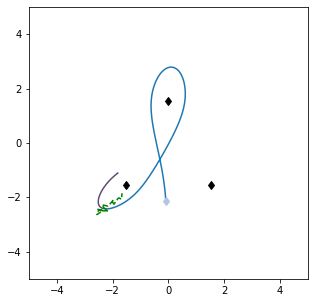

Accuracy over all points in all simulations: 0.493
Accuracy over all simulations: 0.1
Accuracy over all points in all simulations: 0.4925
Accuracy over all simulations: 0.14
Accuracy over all points in all simulations: 0.5436666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.21it/s]


Epoch [17/100] Training loss: 0.0239
Accuracy over all points in all simulations: 0.46732673267326735
Show progress of validation dataset


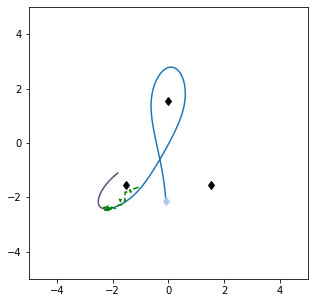

Accuracy over all points in all simulations: 0.4695
Accuracy over all simulations: 0.04
Accuracy over all points in all simulations: 0.469
Accuracy over all simulations: 0.07333333333333333
Accuracy over all points in all simulations: 0.48933333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 86.21it/s]


Epoch [18/100] Training loss: 0.0243
Accuracy over all points in all simulations: 0.5910891089108911
Show progress of validation dataset


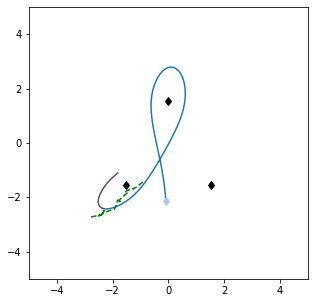

Accuracy over all points in all simulations: 0.5355
Accuracy over all simulations: 0.07
Accuracy over all points in all simulations: 0.5355
Accuracy over all simulations: 0.16
Accuracy over all points in all simulations: 0.625


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 77.31it/s]


Epoch [19/100] Training loss: 0.0220
Accuracy over all points in all simulations: 0.5386138613861386
Show progress of validation dataset


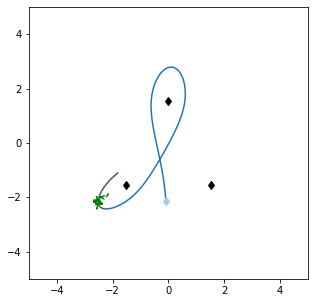

Accuracy over all points in all simulations: 0.447
Accuracy over all simulations: 0.08
Accuracy over all points in all simulations: 0.4465
Accuracy over all simulations: 0.10666666666666667
Accuracy over all points in all simulations: 0.5776666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.21it/s]


Epoch [20/100] Training loss: 0.0189
Accuracy over all points in all simulations: 0.6232673267326733
Show progress of validation dataset


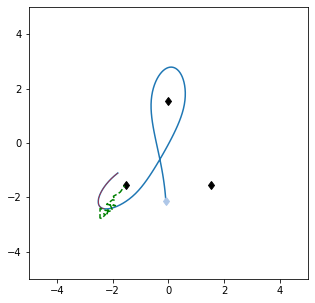

Accuracy over all points in all simulations: 0.572
Accuracy over all simulations: 0.13
Accuracy over all points in all simulations: 0.572
Accuracy over all simulations: 0.21333333333333335
Accuracy over all points in all simulations: 0.66


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.65it/s]


Epoch [21/100] Training loss: 0.0167
Accuracy over all points in all simulations: 0.6242574257425743
Show progress of validation dataset


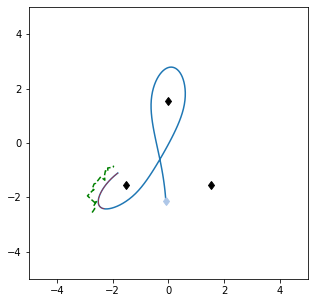

Accuracy over all points in all simulations: 0.505
Accuracy over all simulations: 0.1
Accuracy over all points in all simulations: 0.505
Accuracy over all simulations: 0.22
Accuracy over all points in all simulations: 0.6623333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 72.82it/s]


Epoch [22/100] Training loss: 0.0157
Accuracy over all points in all simulations: 0.6955445544554455
Show progress of validation dataset


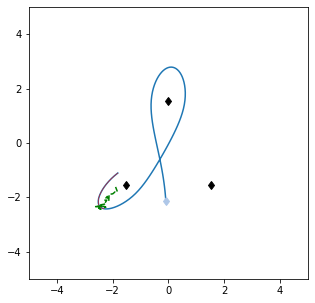

Accuracy over all points in all simulations: 0.602
Accuracy over all simulations: 0.17
Accuracy over all points in all simulations: 0.602
Accuracy over all simulations: 0.2866666666666667
Accuracy over all points in all simulations: 0.726


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 73.17it/s]


Epoch [23/100] Training loss: 0.0137
Accuracy over all points in all simulations: 0.7331683168316832
Show progress of validation dataset


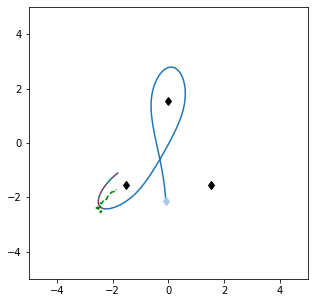

Accuracy over all points in all simulations: 0.6245
Accuracy over all simulations: 0.19
Accuracy over all points in all simulations: 0.6245
Accuracy over all simulations: 0.30666666666666664
Accuracy over all points in all simulations: 0.7543333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 90.91it/s]

Epoch [24/100] Training loss: 0.0120


Accuracy over all points in all simulations: 0.7133663366336633
Show progress of validation dataset


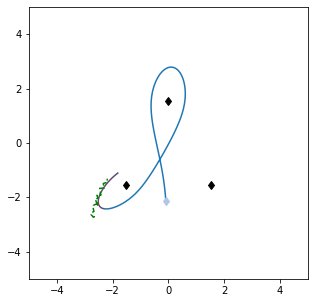

Accuracy over all points in all simulations: 0.5995
Accuracy over all simulations: 0.21
Accuracy over all points in all simulations: 0.6
Accuracy over all simulations: 0.32
Accuracy over all points in all simulations: 0.736


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.40it/s]

Epoch [25/100] Training loss: 0.0112


Accuracy over all points in all simulations: 0.751980198019802
Show progress of validation dataset


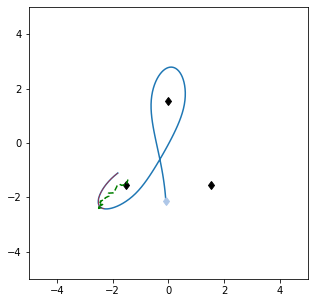

Accuracy over all points in all simulations: 0.6175
Accuracy over all simulations: 0.18
Accuracy over all points in all simulations: 0.6175
Accuracy over all simulations: 0.3333333333333333
Accuracy over all points in all simulations: 0.7816666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 77.31it/s]


Epoch [26/100] Training loss: 0.0118
Accuracy over all points in all simulations: 0.7301980198019802
Show progress of validation dataset


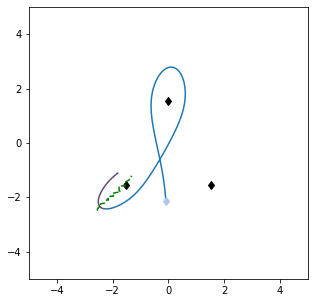

Accuracy over all points in all simulations: 0.5565
Accuracy over all simulations: 0.14
Accuracy over all points in all simulations: 0.5565
Accuracy over all simulations: 0.36666666666666664
Accuracy over all points in all simulations: 0.7536666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 77.94it/s]


Epoch [27/100] Training loss: 0.0111
Accuracy over all points in all simulations: 0.7534653465346535
Show progress of validation dataset


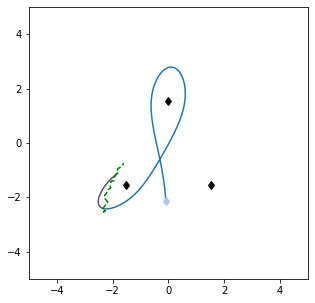

Accuracy over all points in all simulations: 0.583
Accuracy over all simulations: 0.17
Accuracy over all points in all simulations: 0.583
Accuracy over all simulations: 0.38
Accuracy over all points in all simulations: 0.7763333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 81.28it/s]

Epoch [28/100] Training loss: 0.0125


Accuracy over all points in all simulations: 0.698019801980198
Show progress of validation dataset


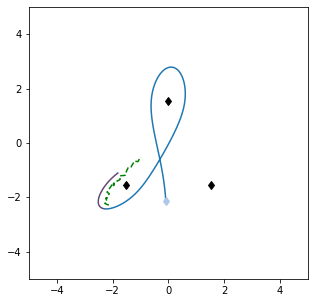

Accuracy over all points in all simulations: 0.5635
Accuracy over all simulations: 0.13
Accuracy over all points in all simulations: 0.5635
Accuracy over all simulations: 0.32
Accuracy over all points in all simulations: 0.738


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 77.80it/s]


Epoch [29/100] Training loss: 0.0133
Accuracy over all points in all simulations: 0.6381188118811881
Show progress of validation dataset


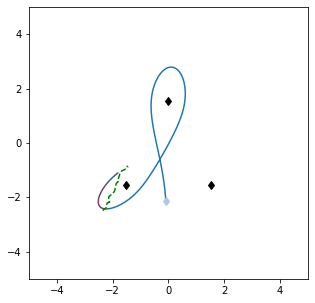

Accuracy over all points in all simulations: 0.541
Accuracy over all simulations: 0.1
Accuracy over all points in all simulations: 0.541
Accuracy over all simulations: 0.2866666666666667
Accuracy over all points in all simulations: 0.675


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 85.08it/s]

Epoch [30/100] Training loss: 0.0127


Accuracy over all points in all simulations: 0.7435643564356436
Show progress of validation dataset


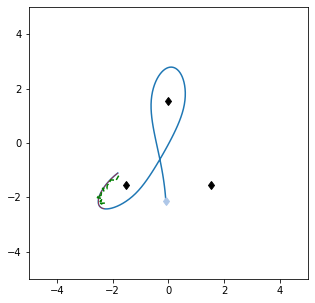

Accuracy over all points in all simulations: 0.663
Accuracy over all simulations: 0.28
Accuracy over all points in all simulations: 0.663
Accuracy over all simulations: 0.3466666666666667
Accuracy over all points in all simulations: 0.775


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.02it/s]


Epoch [31/100] Training loss: 0.0107
Accuracy over all points in all simulations: 0.6391089108910891
Show progress of validation dataset


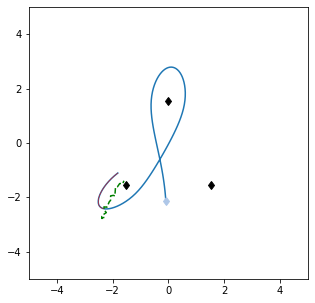

Accuracy over all points in all simulations: 0.5685
Accuracy over all simulations: 0.16
Accuracy over all points in all simulations: 0.5685
Accuracy over all simulations: 0.3466666666666667
Accuracy over all points in all simulations: 0.6926666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 78.13it/s]


Epoch [32/100] Training loss: 0.0109
Accuracy over all points in all simulations: 0.6965346534653465
Show progress of validation dataset


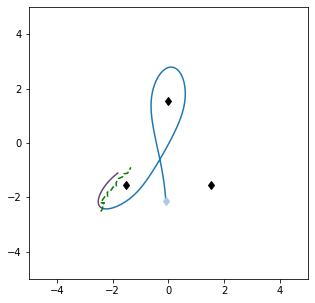

Accuracy over all points in all simulations: 0.5785
Accuracy over all simulations: 0.19
Accuracy over all points in all simulations: 0.577
Accuracy over all simulations: 0.36666666666666664
Accuracy over all points in all simulations: 0.717


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 79.77it/s]


Epoch [33/100] Training loss: 0.0112
Accuracy over all points in all simulations: 0.6811881188118812
Show progress of validation dataset


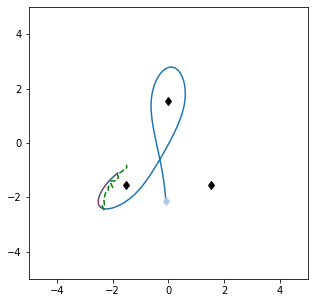

Accuracy over all points in all simulations: 0.598
Accuracy over all simulations: 0.2
Accuracy over all points in all simulations: 0.5975
Accuracy over all simulations: 0.31333333333333335
Accuracy over all points in all simulations: 0.7096666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 89.63it/s]

Epoch [34/100] Training loss: 0.0103


Accuracy over all points in all simulations: 0.7841584158415842
Show progress of validation dataset


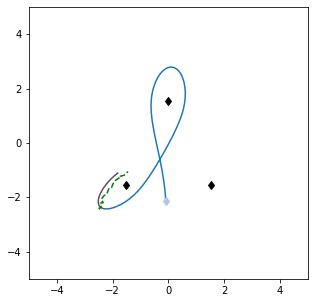

Accuracy over all points in all simulations: 0.6195
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.6195
Accuracy over all simulations: 0.3933333333333333
Accuracy over all points in all simulations: 0.8076666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 84.27it/s]


Epoch [35/100] Training loss: 0.0083
Accuracy over all points in all simulations: 0.7925742574257426
Show progress of validation dataset


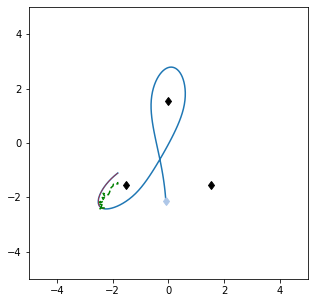

Accuracy over all points in all simulations: 0.627
Accuracy over all simulations: 0.15
Accuracy over all points in all simulations: 0.627
Accuracy over all simulations: 0.47333333333333333
Accuracy over all points in all simulations: 0.8416666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 83.86it/s]


Epoch [36/100] Training loss: 0.0090
Accuracy over all points in all simulations: 0.7217821782178218
Show progress of validation dataset


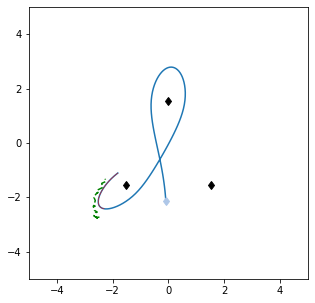

Accuracy over all points in all simulations: 0.5705
Accuracy over all simulations: 0.19
Accuracy over all points in all simulations: 0.571
Accuracy over all simulations: 0.46
Accuracy over all points in all simulations: 0.7753333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 79.50it/s]


Epoch [37/100] Training loss: 0.0090
Accuracy over all points in all simulations: 0.851980198019802
Show progress of validation dataset


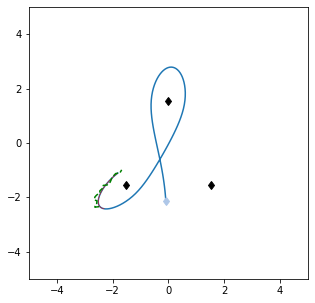

Accuracy over all points in all simulations: 0.6505
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.6505
Accuracy over all simulations: 0.5
Accuracy over all points in all simulations: 0.862


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 76.52it/s]


Epoch [38/100] Training loss: 0.0077
Accuracy over all points in all simulations: 0.7871287128712872
Show progress of validation dataset


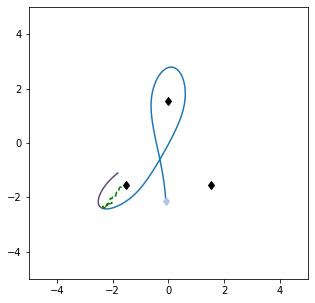

Accuracy over all points in all simulations: 0.667
Accuracy over all simulations: 0.25
Accuracy over all points in all simulations: 0.667
Accuracy over all simulations: 0.46
Accuracy over all points in all simulations: 0.8186666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 57.25it/s]


Epoch [39/100] Training loss: 0.0089
Accuracy over all points in all simulations: 0.7292079207920792
Show progress of validation dataset


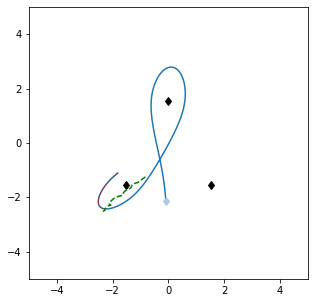

Accuracy over all points in all simulations: 0.56
Accuracy over all simulations: 0.17
Accuracy over all points in all simulations: 0.56
Accuracy over all simulations: 0.35333333333333333
Accuracy over all points in all simulations: 0.7513333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.76it/s]


Epoch [40/100] Training loss: 0.0086
Accuracy over all points in all simulations: 0.8693069306930693
Show progress of validation dataset


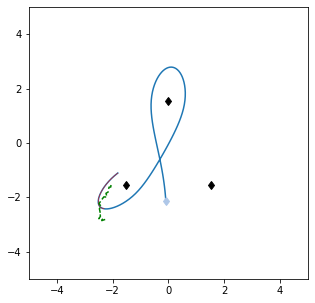

Accuracy over all points in all simulations: 0.669
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.669
Accuracy over all simulations: 0.6066666666666667
Accuracy over all points in all simulations: 0.8853333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.35it/s]


Epoch [41/100] Training loss: 0.0059
Accuracy over all points in all simulations: 0.7851485148514852
Show progress of validation dataset


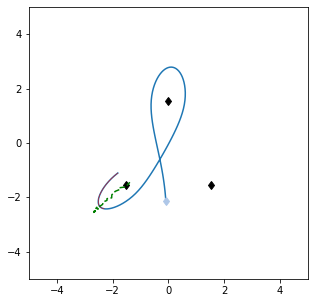

Accuracy over all points in all simulations: 0.6415
Accuracy over all simulations: 0.26
Accuracy over all points in all simulations: 0.642
Accuracy over all simulations: 0.5066666666666667
Accuracy over all points in all simulations: 0.8386666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.25it/s]


Epoch [42/100] Training loss: 0.0065
Accuracy over all points in all simulations: 0.8638613861386139
Show progress of validation dataset


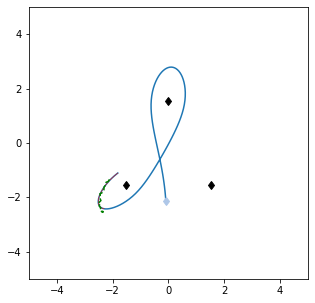

Accuracy over all points in all simulations: 0.6625
Accuracy over all simulations: 0.26
Accuracy over all points in all simulations: 0.662
Accuracy over all simulations: 0.5533333333333333
Accuracy over all points in all simulations: 0.88


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.12it/s]


Epoch [43/100] Training loss: 0.0062
Accuracy over all points in all simulations: 0.8391089108910891
Show progress of validation dataset


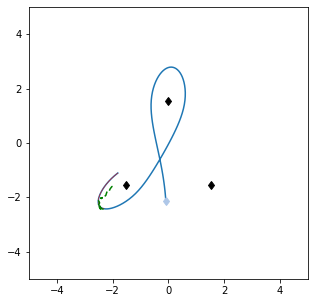

Accuracy over all points in all simulations: 0.683
Accuracy over all simulations: 0.27
Accuracy over all points in all simulations: 0.6825
Accuracy over all simulations: 0.5733333333333334
Accuracy over all points in all simulations: 0.87


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 79.80it/s]


Epoch [44/100] Training loss: 0.0058
Accuracy over all points in all simulations: 0.846039603960396
Show progress of validation dataset


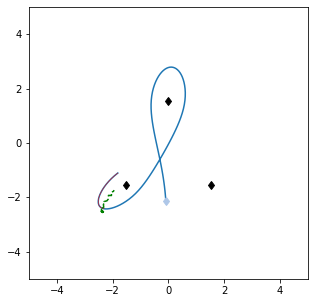

Accuracy over all points in all simulations: 0.677
Accuracy over all simulations: 0.3
Accuracy over all points in all simulations: 0.677
Accuracy over all simulations: 0.6266666666666667
Accuracy over all points in all simulations: 0.8713333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 78.04it/s]


Epoch [45/100] Training loss: 0.0071
Accuracy over all points in all simulations: 0.8113861386138614
Show progress of validation dataset


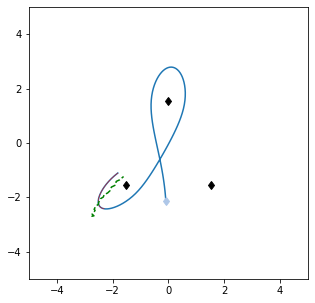

Accuracy over all points in all simulations: 0.591
Accuracy over all simulations: 0.17
Accuracy over all points in all simulations: 0.5895
Accuracy over all simulations: 0.48
Accuracy over all points in all simulations: 0.8173333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 76.79it/s]


Epoch [46/100] Training loss: 0.0061
Accuracy over all points in all simulations: 0.9123762376237624
Show progress of validation dataset


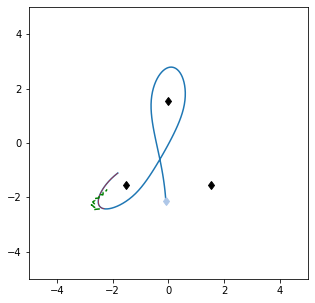

Accuracy over all points in all simulations: 0.637
Accuracy over all simulations: 0.21
Accuracy over all points in all simulations: 0.6375
Accuracy over all simulations: 0.6466666666666666
Accuracy over all points in all simulations: 0.9173333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 73.17it/s]


Epoch [47/100] Training loss: 0.0055
Accuracy over all points in all simulations: 0.8084158415841585
Show progress of validation dataset


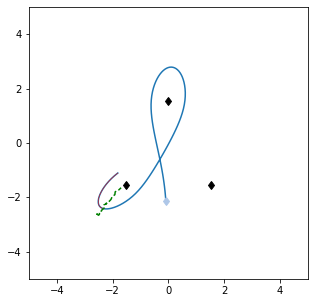

Accuracy over all points in all simulations: 0.6335
Accuracy over all simulations: 0.23
Accuracy over all points in all simulations: 0.6335
Accuracy over all simulations: 0.5866666666666667
Accuracy over all points in all simulations: 0.8466666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 76.92it/s]


Epoch [48/100] Training loss: 0.0063
Accuracy over all points in all simulations: 0.8702970297029703
Show progress of validation dataset


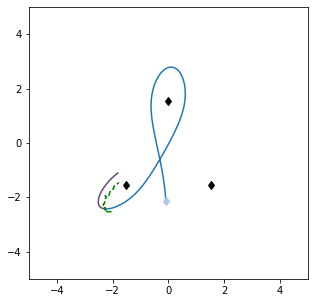

Accuracy over all points in all simulations: 0.6715
Accuracy over all simulations: 0.26
Accuracy over all points in all simulations: 0.6725
Accuracy over all simulations: 0.66
Accuracy over all points in all simulations: 0.8913333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 77.19it/s]


Epoch [49/100] Training loss: 0.0061
Accuracy over all points in all simulations: 0.8905940594059406
Show progress of validation dataset


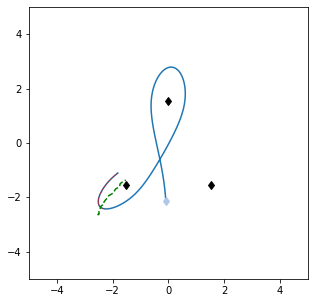

Accuracy over all points in all simulations: 0.654
Accuracy over all simulations: 0.21
Accuracy over all points in all simulations: 0.6545
Accuracy over all simulations: 0.66
Accuracy over all points in all simulations: 0.9043333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 71.09it/s]


Epoch [50/100] Training loss: 0.0056
Accuracy over all points in all simulations: 0.8410891089108911
Show progress of validation dataset


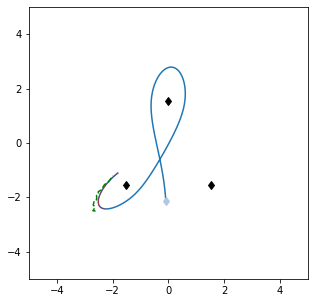

Accuracy over all points in all simulations: 0.6175
Accuracy over all simulations: 0.21
Accuracy over all points in all simulations: 0.6175
Accuracy over all simulations: 0.5733333333333334
Accuracy over all points in all simulations: 0.8493333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.32it/s]

Epoch [51/100] Training loss: 0.0057


Accuracy over all points in all simulations: 0.8856435643564357
Show progress of validation dataset


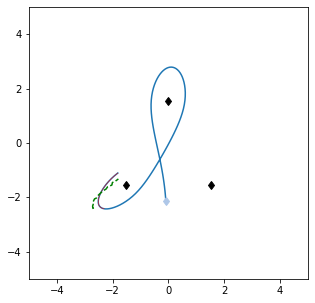

Accuracy over all points in all simulations: 0.6635
Accuracy over all simulations: 0.28
Accuracy over all points in all simulations: 0.663
Accuracy over all simulations: 0.68
Accuracy over all points in all simulations: 0.9103333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 79.78it/s]


Epoch [52/100] Training loss: 0.0050
Accuracy over all points in all simulations: 0.8599009900990099
Show progress of validation dataset


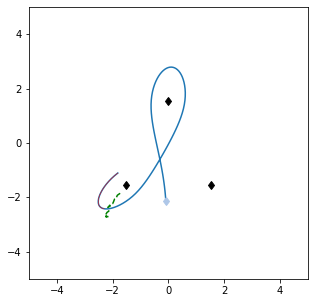

Accuracy over all points in all simulations: 0.672
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.672
Accuracy over all simulations: 0.68
Accuracy over all points in all simulations: 0.8926666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 70.04it/s]


Epoch [53/100] Training loss: 0.0053
Accuracy over all points in all simulations: 0.843069306930693
Show progress of validation dataset


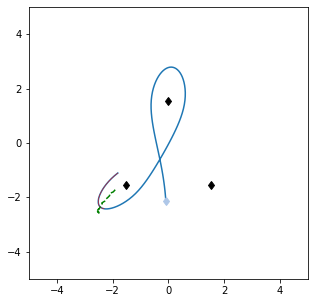

Accuracy over all points in all simulations: 0.6745
Accuracy over all simulations: 0.31
Accuracy over all points in all simulations: 0.675
Accuracy over all simulations: 0.56
Accuracy over all points in all simulations: 0.8616666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 78.82it/s]


Epoch [54/100] Training loss: 0.0059
Accuracy over all points in all simulations: 0.8930693069306931
Show progress of validation dataset


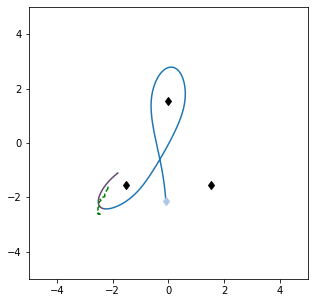

Accuracy over all points in all simulations: 0.6635
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.6625
Accuracy over all simulations: 0.7
Accuracy over all points in all simulations: 0.911


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 73.53it/s]


Epoch [55/100] Training loss: 0.0057
Accuracy over all points in all simulations: 0.8198019801980198
Show progress of validation dataset


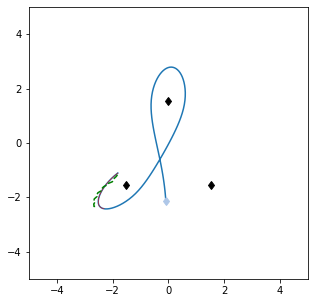

Accuracy over all points in all simulations: 0.592
Accuracy over all simulations: 0.21
Accuracy over all points in all simulations: 0.5935
Accuracy over all simulations: 0.58
Accuracy over all points in all simulations: 0.836


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 57.69it/s]


Epoch [56/100] Training loss: 0.0069
Accuracy over all points in all simulations: 0.8475247524752475
Show progress of validation dataset


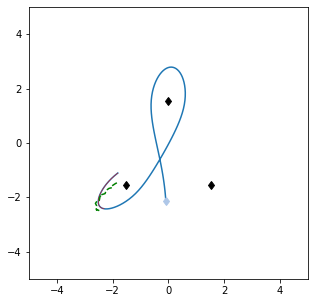

Accuracy over all points in all simulations: 0.6525
Accuracy over all simulations: 0.21
Accuracy over all points in all simulations: 0.6515
Accuracy over all simulations: 0.64
Accuracy over all points in all simulations: 0.8803333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 79.52it/s]


Epoch [57/100] Training loss: 0.0072
Accuracy over all points in all simulations: 0.804950495049505
Show progress of validation dataset


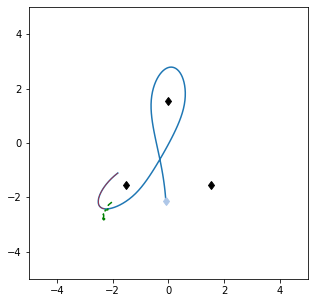

Accuracy over all points in all simulations: 0.6515
Accuracy over all simulations: 0.22
Accuracy over all points in all simulations: 0.6525
Accuracy over all simulations: 0.5733333333333334
Accuracy over all points in all simulations: 0.843


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.76it/s]


Epoch [58/100] Training loss: 0.0074
Accuracy over all points in all simulations: 0.8559405940594059
Show progress of validation dataset


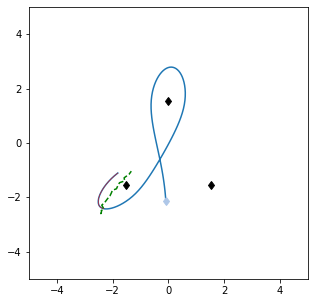

Accuracy over all points in all simulations: 0.6735
Accuracy over all simulations: 0.26
Accuracy over all points in all simulations: 0.673
Accuracy over all simulations: 0.58
Accuracy over all points in all simulations: 0.877


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 81.18it/s]


Epoch [59/100] Training loss: 0.0071
Accuracy over all points in all simulations: 0.8193069306930693
Show progress of validation dataset


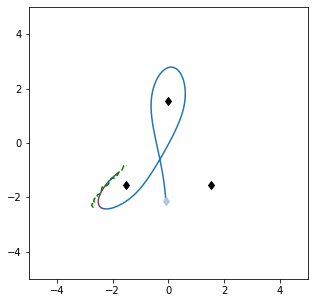

Accuracy over all points in all simulations: 0.6195
Accuracy over all simulations: 0.22
Accuracy over all points in all simulations: 0.619
Accuracy over all simulations: 0.58
Accuracy over all points in all simulations: 0.846


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 85.94it/s]

Epoch [60/100] Training loss: 0.0062


Accuracy over all points in all simulations: 0.8648514851485148
Show progress of validation dataset


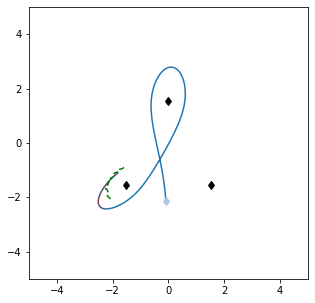

Accuracy over all points in all simulations: 0.6165
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.6155
Accuracy over all simulations: 0.6133333333333333
Accuracy over all points in all simulations: 0.8806666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.21it/s]


Epoch [61/100] Training loss: 0.0054
Accuracy over all points in all simulations: 0.8178217821782178
Show progress of validation dataset


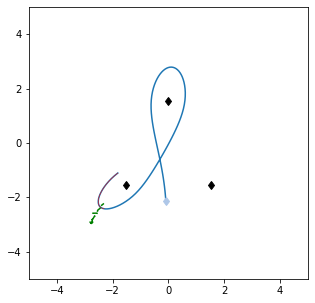

Accuracy over all points in all simulations: 0.635
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.6355
Accuracy over all simulations: 0.5666666666666667
Accuracy over all points in all simulations: 0.8613333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 75.00it/s]


Epoch [62/100] Training loss: 0.0059
Accuracy over all points in all simulations: 0.8539603960396039
Show progress of validation dataset


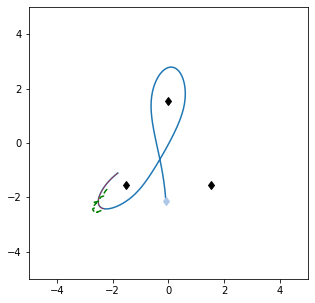

Accuracy over all points in all simulations: 0.6725
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.673
Accuracy over all simulations: 0.6066666666666667
Accuracy over all points in all simulations: 0.8746666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 81.21it/s]


Epoch [63/100] Training loss: 0.0061
Accuracy over all points in all simulations: 0.8574257425742574
Show progress of validation dataset


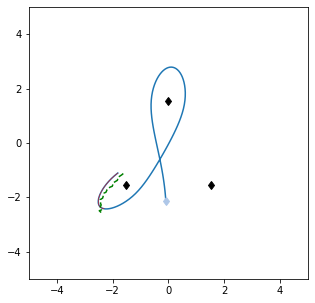

Accuracy over all points in all simulations: 0.664
Accuracy over all simulations: 0.27
Accuracy over all points in all simulations: 0.664
Accuracy over all simulations: 0.64
Accuracy over all points in all simulations: 0.8816666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.91it/s]


Epoch [64/100] Training loss: 0.0047
Accuracy over all points in all simulations: 0.8643564356435643
Show progress of validation dataset


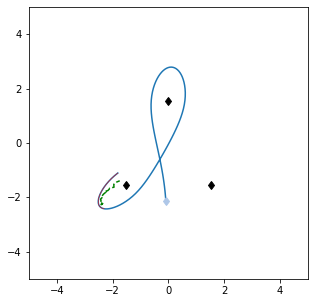

Accuracy over all points in all simulations: 0.6105
Accuracy over all simulations: 0.26
Accuracy over all points in all simulations: 0.6105
Accuracy over all simulations: 0.68
Accuracy over all points in all simulations: 0.8813333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 81.07it/s]


Epoch [65/100] Training loss: 0.0055
Accuracy over all points in all simulations: 0.8905940594059406
Show progress of validation dataset


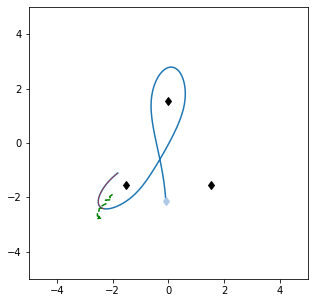

Accuracy over all points in all simulations: 0.6475
Accuracy over all simulations: 0.23
Accuracy over all points in all simulations: 0.6475
Accuracy over all simulations: 0.6666666666666666
Accuracy over all points in all simulations: 0.9136666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 83.78it/s]


Epoch [66/100] Training loss: 0.0054
Accuracy over all points in all simulations: 0.8485148514851485
Show progress of validation dataset


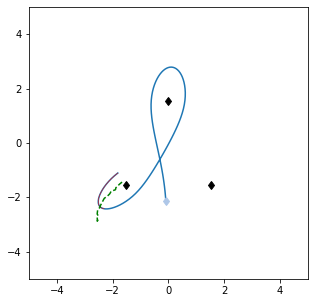

Accuracy over all points in all simulations: 0.65
Accuracy over all simulations: 0.25
Accuracy over all points in all simulations: 0.65
Accuracy over all simulations: 0.6666666666666666
Accuracy over all points in all simulations: 0.8773333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.40it/s]


Epoch [67/100] Training loss: 0.0055
Accuracy over all points in all simulations: 0.8811881188118812
Show progress of validation dataset


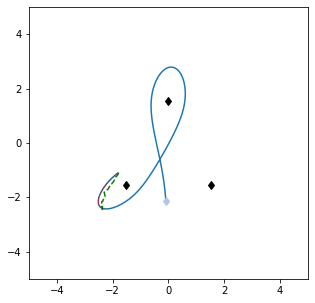

Accuracy over all points in all simulations: 0.6995
Accuracy over all simulations: 0.28
Accuracy over all points in all simulations: 0.6995
Accuracy over all simulations: 0.6466666666666666
Accuracy over all points in all simulations: 0.9


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 84.15it/s]


Epoch [68/100] Training loss: 0.0077
Accuracy over all points in all simulations: 0.8074257425742575
Show progress of validation dataset


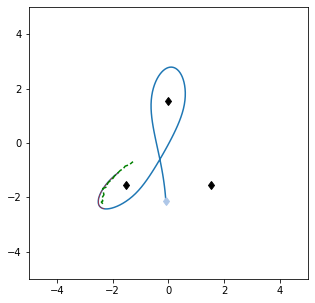

Accuracy over all points in all simulations: 0.6005
Accuracy over all simulations: 0.2
Accuracy over all points in all simulations: 0.601
Accuracy over all simulations: 0.5466666666666666
Accuracy over all points in all simulations: 0.8153333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.64it/s]


Epoch [69/100] Training loss: 0.0073
Accuracy over all points in all simulations: 0.8549504950495049
Show progress of validation dataset


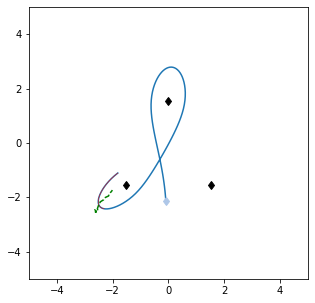

Accuracy over all points in all simulations: 0.6745
Accuracy over all simulations: 0.28
Accuracy over all points in all simulations: 0.6745
Accuracy over all simulations: 0.6333333333333333
Accuracy over all points in all simulations: 0.8716666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 81.52it/s]


Epoch [70/100] Training loss: 0.0057
Accuracy over all points in all simulations: 0.8084158415841585
Show progress of validation dataset


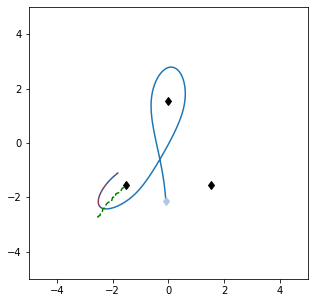

Accuracy over all points in all simulations: 0.652
Accuracy over all simulations: 0.23
Accuracy over all points in all simulations: 0.6525
Accuracy over all simulations: 0.62
Accuracy over all points in all simulations: 0.8463333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 79.79it/s]


Epoch [71/100] Training loss: 0.0068
Accuracy over all points in all simulations: 0.9178217821782179
Show progress of validation dataset


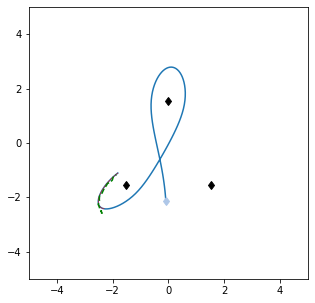

Accuracy over all points in all simulations: 0.692
Accuracy over all simulations: 0.28
Accuracy over all points in all simulations: 0.6925
Accuracy over all simulations: 0.7333333333333333
Accuracy over all points in all simulations: 0.935


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 53.18it/s]


Epoch [72/100] Training loss: 0.0048
Accuracy over all points in all simulations: 0.8638613861386139
Show progress of validation dataset


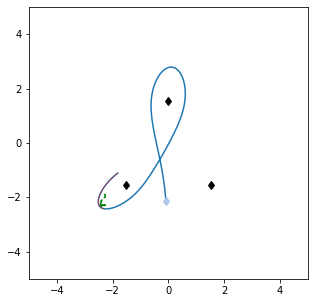

Accuracy over all points in all simulations: 0.6605
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.6605
Accuracy over all simulations: 0.6333333333333333
Accuracy over all points in all simulations: 0.887


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.80it/s]


Epoch [73/100] Training loss: 0.0047
Accuracy over all points in all simulations: 0.8841584158415842
Show progress of validation dataset


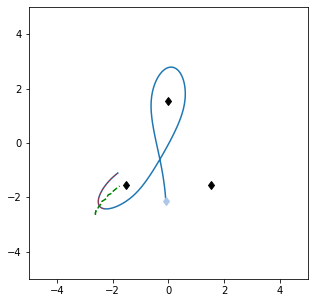

Accuracy over all points in all simulations: 0.646
Accuracy over all simulations: 0.19
Accuracy over all points in all simulations: 0.6455
Accuracy over all simulations: 0.7066666666666667
Accuracy over all points in all simulations: 0.9103333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.42it/s]


Epoch [74/100] Training loss: 0.0038
Accuracy over all points in all simulations: 0.943069306930693
Show progress of validation dataset


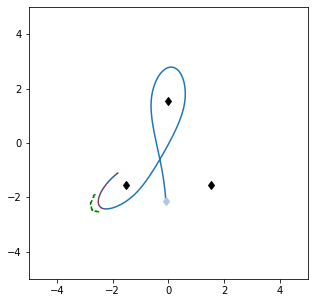

Accuracy over all points in all simulations: 0.664
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.665
Accuracy over all simulations: 0.7866666666666666
Accuracy over all points in all simulations: 0.9563333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 64.09it/s]


Epoch [75/100] Training loss: 0.0038
Accuracy over all points in all simulations: 0.9564356435643564
Show progress of validation dataset


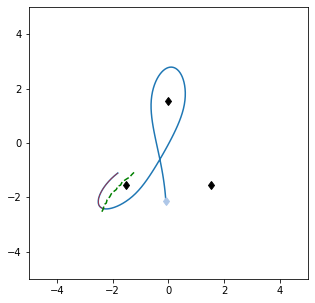

Accuracy over all points in all simulations: 0.6905
Accuracy over all simulations: 0.28
Accuracy over all points in all simulations: 0.69
Accuracy over all simulations: 0.8333333333333334
Accuracy over all points in all simulations: 0.9623333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 79.35it/s]


Epoch [76/100] Training loss: 0.0032
Accuracy over all points in all simulations: 0.9183168316831684
Show progress of validation dataset


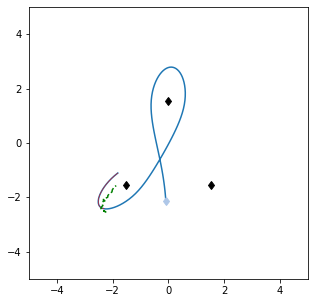

Accuracy over all points in all simulations: 0.671
Accuracy over all simulations: 0.29
Accuracy over all points in all simulations: 0.671
Accuracy over all simulations: 0.7533333333333333
Accuracy over all points in all simulations: 0.9363333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.64it/s]


Epoch [77/100] Training loss: 0.0039
Accuracy over all points in all simulations: 0.946039603960396
Show progress of validation dataset


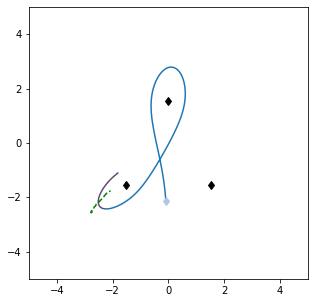

Accuracy over all points in all simulations: 0.666
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.666
Accuracy over all simulations: 0.8066666666666666
Accuracy over all points in all simulations: 0.9553333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 54.16it/s]


Epoch [78/100] Training loss: 0.0032
Accuracy over all points in all simulations: 0.9608910891089109
Show progress of validation dataset


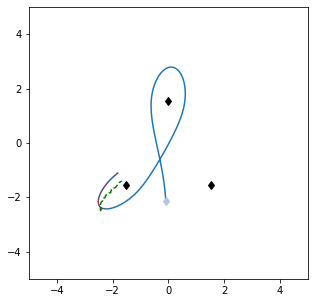

Accuracy over all points in all simulations: 0.686
Accuracy over all simulations: 0.25
Accuracy over all points in all simulations: 0.6855
Accuracy over all simulations: 0.8466666666666667
Accuracy over all points in all simulations: 0.9713333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.63it/s]


Epoch [79/100] Training loss: 0.0033
Accuracy over all points in all simulations: 0.9693069306930693
Show progress of validation dataset


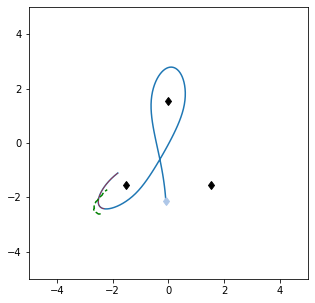

Accuracy over all points in all simulations: 0.704
Accuracy over all simulations: 0.27
Accuracy over all points in all simulations: 0.7045
Accuracy over all simulations: 0.86
Accuracy over all points in all simulations: 0.975


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.40it/s]


Epoch [80/100] Training loss: 0.0028
Accuracy over all points in all simulations: 0.9445544554455445
Show progress of validation dataset


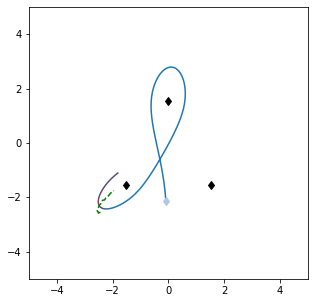

Accuracy over all points in all simulations: 0.716
Accuracy over all simulations: 0.33
Accuracy over all points in all simulations: 0.715
Accuracy over all simulations: 0.8133333333333334
Accuracy over all points in all simulations: 0.9546666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 54.94it/s]


Epoch [81/100] Training loss: 0.0037
Accuracy over all points in all simulations: 0.9014851485148515
Show progress of validation dataset


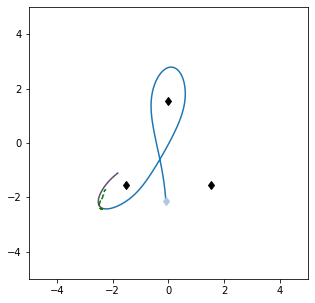

Accuracy over all points in all simulations: 0.647
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.6475
Accuracy over all simulations: 0.7466666666666667
Accuracy over all points in all simulations: 0.921


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 78.11it/s]


Epoch [82/100] Training loss: 0.0038
Accuracy over all points in all simulations: 0.9242574257425743
Show progress of validation dataset


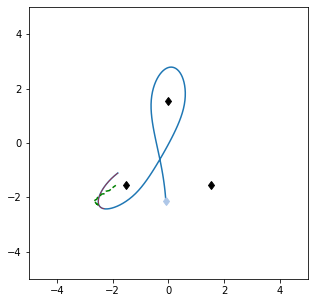

Accuracy over all points in all simulations: 0.6205
Accuracy over all simulations: 0.26
Accuracy over all points in all simulations: 0.621
Accuracy over all simulations: 0.74
Accuracy over all points in all simulations: 0.937


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 92.57it/s]

Epoch [83/100] Training loss: 0.0045


Accuracy over all points in all simulations: 0.8633663366336634
Show progress of validation dataset


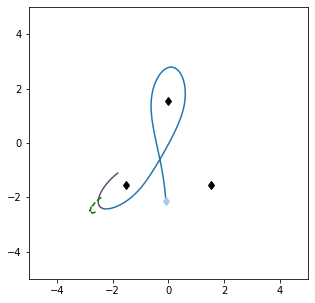

Accuracy over all points in all simulations: 0.639
Accuracy over all simulations: 0.26
Accuracy over all points in all simulations: 0.638
Accuracy over all simulations: 0.7
Accuracy over all points in all simulations: 0.898


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 87.41it/s]

Epoch [84/100] Training loss: 0.0052


Accuracy over all points in all simulations: 0.9202970297029703
Show progress of validation dataset


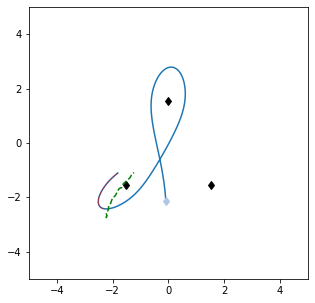

Accuracy over all points in all simulations: 0.691
Accuracy over all simulations: 0.26
Accuracy over all points in all simulations: 0.6915
Accuracy over all simulations: 0.7466666666666667
Accuracy over all points in all simulations: 0.9316666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 81.19it/s]


Epoch [85/100] Training loss: 0.0058
Accuracy over all points in all simulations: 0.7955445544554456
Show progress of validation dataset


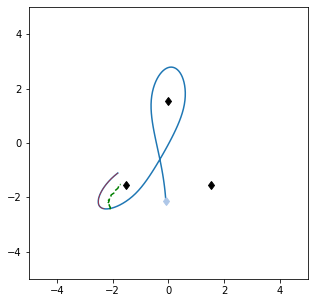

Accuracy over all points in all simulations: 0.622
Accuracy over all simulations: 0.26
Accuracy over all points in all simulations: 0.6215
Accuracy over all simulations: 0.5866666666666667
Accuracy over all points in all simulations: 0.8296666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.65it/s]


Epoch [86/100] Training loss: 0.0068
Accuracy over all points in all simulations: 0.8603960396039604
Show progress of validation dataset


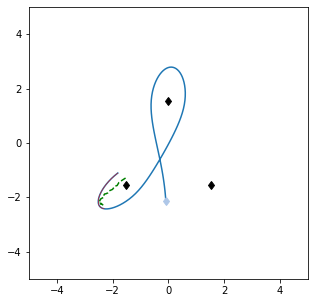

Accuracy over all points in all simulations: 0.6
Accuracy over all simulations: 0.22
Accuracy over all points in all simulations: 0.6015
Accuracy over all simulations: 0.6533333333333333
Accuracy over all points in all simulations: 0.8733333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 73.75it/s]


Epoch [87/100] Training loss: 0.0062
Accuracy over all points in all simulations: 0.8183168316831683
Show progress of validation dataset


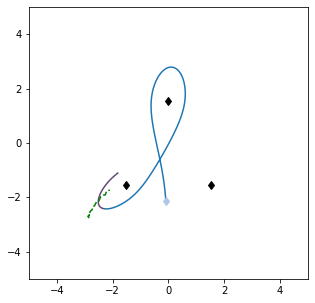

Accuracy over all points in all simulations: 0.613
Accuracy over all simulations: 0.22
Accuracy over all points in all simulations: 0.611
Accuracy over all simulations: 0.5866666666666667
Accuracy over all points in all simulations: 0.8623333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 83.45it/s]

Epoch [88/100] Training loss: 0.0067


Accuracy over all points in all simulations: 0.8272277227722772
Show progress of validation dataset


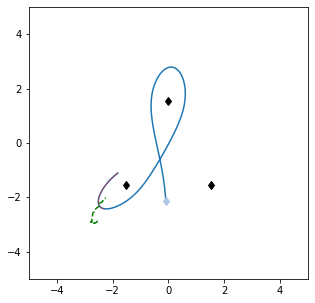

Accuracy over all points in all simulations: 0.6605
Accuracy over all simulations: 0.31
Accuracy over all points in all simulations: 0.6595
Accuracy over all simulations: 0.66
Accuracy over all points in all simulations: 0.8706666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.47it/s]


Epoch [89/100] Training loss: 0.0066
Accuracy over all points in all simulations: 0.8188118811881188
Show progress of validation dataset


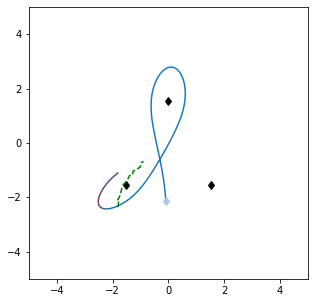

Accuracy over all points in all simulations: 0.6135
Accuracy over all simulations: 0.25
Accuracy over all points in all simulations: 0.614
Accuracy over all simulations: 0.6
Accuracy over all points in all simulations: 0.8386666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 82.39it/s]


Epoch [90/100] Training loss: 0.0078
Accuracy over all points in all simulations: 0.8292079207920792
Show progress of validation dataset


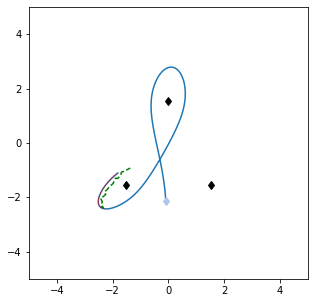

Accuracy over all points in all simulations: 0.5935
Accuracy over all simulations: 0.23
Accuracy over all points in all simulations: 0.5945
Accuracy over all simulations: 0.5666666666666667
Accuracy over all points in all simulations: 0.852


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 88.76it/s]

Epoch [91/100] Training loss: 0.0058


Accuracy over all points in all simulations: 0.8767326732673267
Show progress of validation dataset


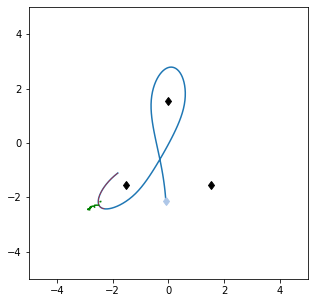

Accuracy over all points in all simulations: 0.6155
Accuracy over all simulations: 0.28
Accuracy over all points in all simulations: 0.6155
Accuracy over all simulations: 0.6666666666666666
Accuracy over all points in all simulations: 0.9006666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 81.50it/s]


Epoch [92/100] Training loss: 0.0069
Accuracy over all points in all simulations: 0.8702970297029703
Show progress of validation dataset


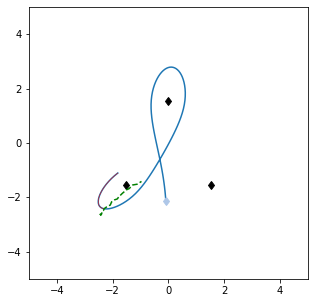

Accuracy over all points in all simulations: 0.6945
Accuracy over all simulations: 0.3
Accuracy over all points in all simulations: 0.6955
Accuracy over all simulations: 0.6533333333333333
Accuracy over all points in all simulations: 0.8916666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 81.06it/s]


Epoch [93/100] Training loss: 0.0054
Accuracy over all points in all simulations: 0.9108910891089109
Show progress of validation dataset


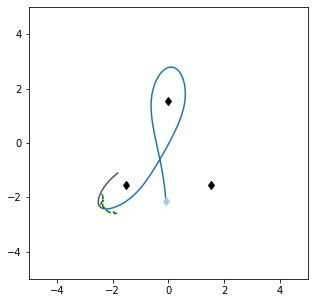

Accuracy over all points in all simulations: 0.6495
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.6505
Accuracy over all simulations: 0.74
Accuracy over all points in all simulations: 0.9223333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 71.15it/s]


Epoch [94/100] Training loss: 0.0043
Accuracy over all points in all simulations: 0.9242574257425743
Show progress of validation dataset


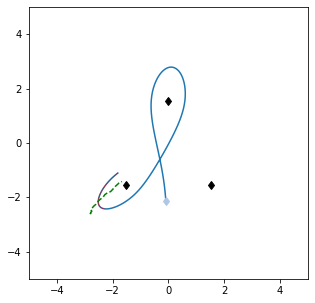

Accuracy over all points in all simulations: 0.699
Accuracy over all simulations: 0.35
Accuracy over all points in all simulations: 0.6995
Accuracy over all simulations: 0.7666666666666667
Accuracy over all points in all simulations: 0.9366666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.62it/s]


Epoch [95/100] Training loss: 0.0032
Accuracy over all points in all simulations: 0.9361386138613862
Show progress of validation dataset


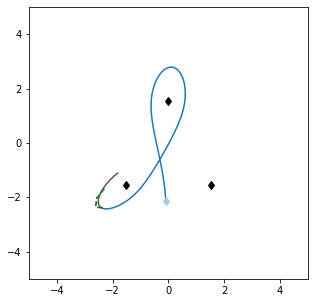

Accuracy over all points in all simulations: 0.6405
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.6415
Accuracy over all simulations: 0.8133333333333334
Accuracy over all points in all simulations: 0.956


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.63it/s]


Epoch [96/100] Training loss: 0.0027
Accuracy over all points in all simulations: 0.9658415841584158
Show progress of validation dataset


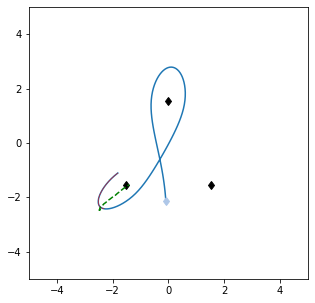

Accuracy over all points in all simulations: 0.692
Accuracy over all simulations: 0.24
Accuracy over all points in all simulations: 0.6935
Accuracy over all simulations: 0.8866666666666667
Accuracy over all points in all simulations: 0.971


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 72.46it/s]


Epoch [97/100] Training loss: 0.0029
Accuracy over all points in all simulations: 0.9485148514851485
Show progress of validation dataset


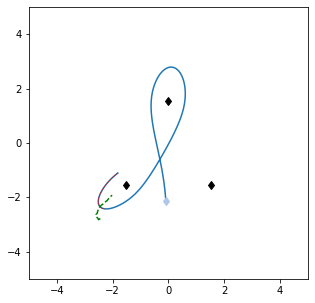

Accuracy over all points in all simulations: 0.703
Accuracy over all simulations: 0.3
Accuracy over all points in all simulations: 0.704
Accuracy over all simulations: 0.8133333333333334
Accuracy over all points in all simulations: 0.961


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 78.16it/s]


Epoch [98/100] Training loss: 0.0030
Accuracy over all points in all simulations: 0.9564356435643564
Show progress of validation dataset


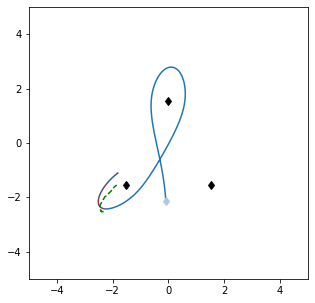

Accuracy over all points in all simulations: 0.7155
Accuracy over all simulations: 0.34
Accuracy over all points in all simulations: 0.7145
Accuracy over all simulations: 0.8866666666666667
Accuracy over all points in all simulations: 0.9693333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 81.45it/s]


Epoch [99/100] Training loss: 0.0026
Accuracy over all points in all simulations: 0.9792079207920792
Show progress of validation dataset


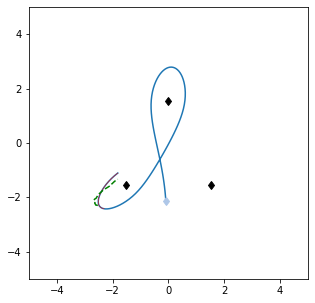

Accuracy over all points in all simulations: 0.6665
Accuracy over all simulations: 0.3
Accuracy over all points in all simulations: 0.6675
Accuracy over all simulations: 0.9066666666666666
Accuracy over all points in all simulations: 0.9793333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 77.72it/s]


Epoch [100/100] Training loss: 0.0024
Accuracy over all points in all simulations: 0.9603960396039604
Show progress of validation dataset


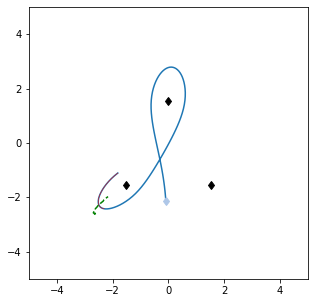

Accuracy over all points in all simulations: 0.658
Accuracy over all simulations: 0.25
Accuracy over all points in all simulations: 0.657
Accuracy over all simulations: 0.8533333333333334
Accuracy over all points in all simulations: 0.971


In [573]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import math

batch_size=10
model32 = Model32(input_size=2, output_size=[20, 2], hidden_dim=100, batch_size=batch_size)
model32 = model32.to(device)

loader = DataLoader(dataset_train_path, batch_size=batch_size)

# Possibly loading the previously trained model
# model32.load_state_dict(torch.load('./model_withforward_2'))

# Hyperparameters
n_epochs = 100
lr=0.01

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model32.parameters(), lr=lr)

metrics32 = {
    'loss': [],
    'valid_acc': [],
    'valid_all_acc': [],
    'train_acc': [],
    'train_all_acc': [],
}

for epoch in range(1, n_epochs + 1):
    total_loss = 0
    model32.train()
    for i, (x, target, total) in enumerate(tqdm(loader)):
        optimizer.zero_grad()
        output = model32(x)
        the_loss = criterion(output, target)
        
        total_loss += the_loss.item()
        the_loss.backward()
        optimizer.step()
    model32.eval()
    print(f"Epoch [{epoch}/{n_epochs}] Training loss: {total_loss/len(dataset_train_path):.4f}")
    calc_accuracy_all_points_32(model32, dataset_train_path)
    print("Show progress of validation dataset")
    show_progress(dataset_valid_path, model32)
    calc_accuracy_all_points_32(model32, dataset_valid_path)
    
    metrics32['loss'].append(total_loss/len(dataset_train))
    metrics32['valid_acc'].append(calc_accuracy_all_simulations_32(model32, dataset_valid_path, 0))
    metrics32['valid_all_acc'].append(calc_accuracy_all_points_32(model32, dataset_valid_path, 0))
    metrics32['train_acc'].append(calc_accuracy_all_simulations_32(model32, dataset_train_path, 0))
    metrics32['train_all_acc'].append(calc_accuracy_all_points_32(model32, dataset_train_path, 0))

In [ ]:
# Save model optionally
# torch.save(model32.state_dict(), './model_withforward_lstm')

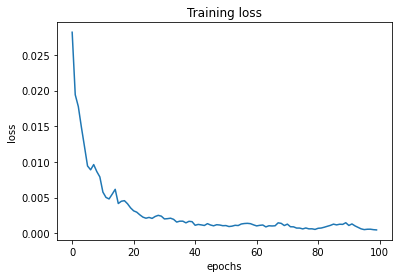

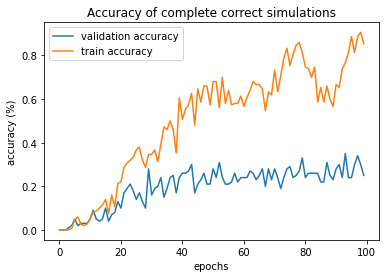

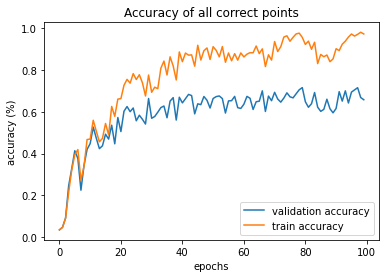

In [574]:
# Loss
fig = plt.figure()
axes = plt.gca()
cmap = matplotlib.cm.get_cmap('tab20')
plt.title("Training loss")
plt.plot(metrics32['loss'], color=cmap(0))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Accuracy
fig = plt.figure()
axes = plt.gca()
cmap = matplotlib.cm.get_cmap('tab20')
plt.title("Accuracy of complete correct simulations")
plt.plot(metrics32['valid_acc'])
plt.plot(metrics32['train_acc'])
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(["validation accuracy", "train accuracy"])
plt.show()

# All charges accuracy
fig = plt.figure()
axes = plt.gca()
cmap = matplotlib.cm.get_cmap('tab20')
plt.title("Accuracy of all correct points")
plt.plot(metrics32['valid_all_acc'])
plt.plot(metrics32['train_all_acc'])
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(["validation accuracy", "train accuracy"])
plt.show()

## Evaluation

In [546]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in range(len(thresholds)):
    threshold = thresholds[i]
    print(f"Calculating for threshold {threshold}")
    # Calculate the accuracy by looping over every point and checking if it is closer to the ground truth than the threshold
    calc_accuracy_all_points_32(model32, dataset_test_path, 0, threshold=threshold)
    # Calculate the accuracy by looping over every simulation and checking if EVERY point in the simulation matches the ground truth
    calc_accuracy_all_simulations_32(model32, dataset_test_path, 0, threshold=threshold)

Calculating for threshold 0.1
Accuracy over all points in all simulations: 0.1455
Accuracy over all simulations: 0.0
Calculating for threshold 0.2
Accuracy over all points in all simulations: 0.344
Accuracy over all simulations: 0.02
Calculating for threshold 0.3
Accuracy over all points in all simulations: 0.481
Accuracy over all simulations: 0.06
Calculating for threshold 0.4
Accuracy over all points in all simulations: 0.606
Accuracy over all simulations: 0.16
Calculating for threshold 0.5
Accuracy over all points in all simulations: 0.709
Accuracy over all simulations: 0.23
Calculating for threshold 0.6
Accuracy over all points in all simulations: 0.7965
Accuracy over all simulations: 0.37
Calculating for threshold 0.7
Accuracy over all points in all simulations: 0.8595
Accuracy over all simulations: 0.5
Calculating for threshold 0.8
Accuracy over all points in all simulations: 0.908
Accuracy over all simulations: 0.62
Calculating for threshold 0.9
Accuracy over all points in all s

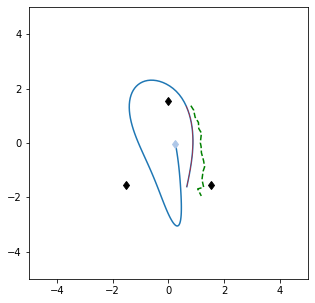

In [537]:
show_progress(dataset_test_path, model32, 6)

In [538]:
is_simulation_close_enough(model32, dataset_test_path, 6)

False

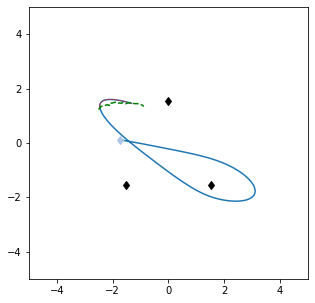

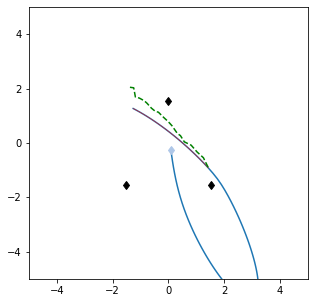

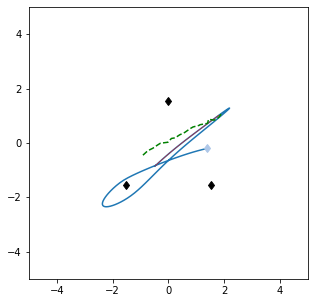

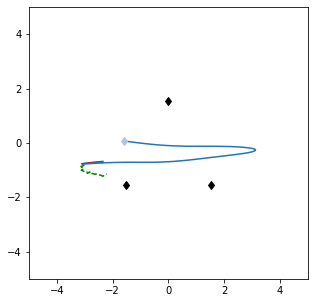

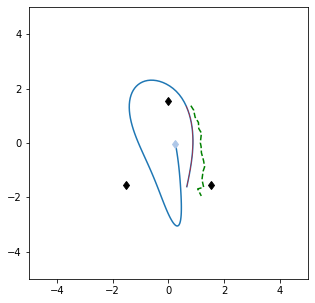

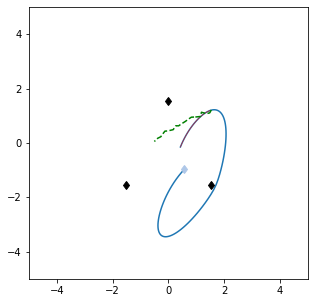

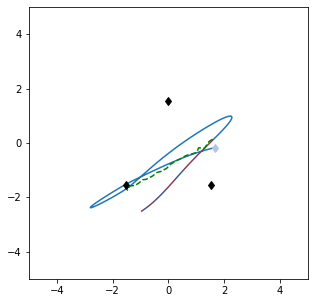

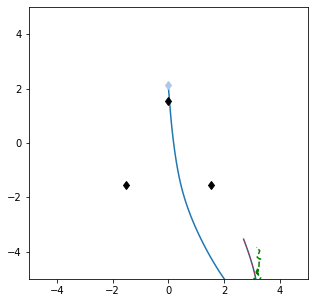

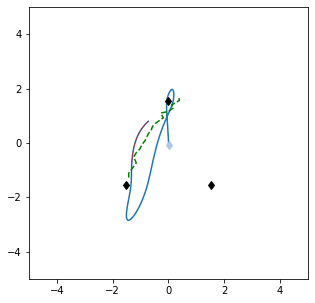

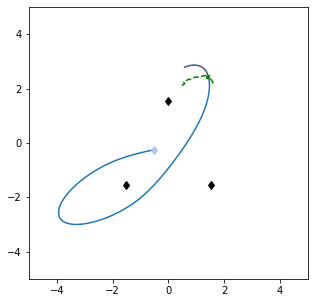

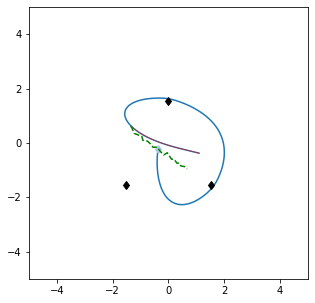

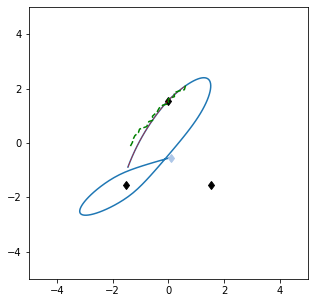

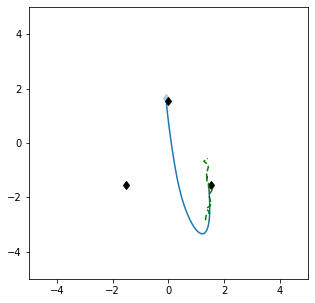

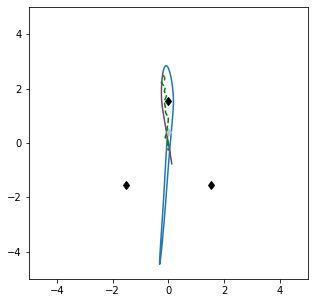

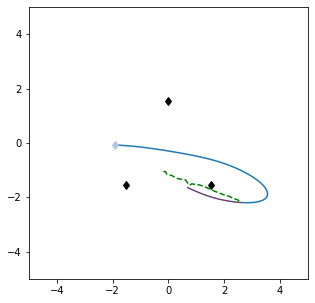

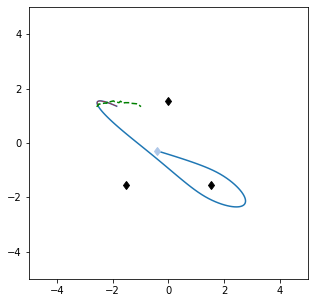

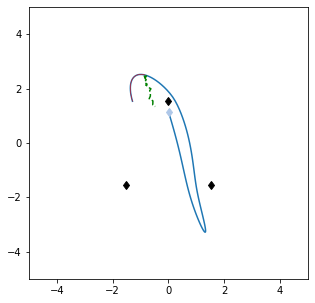

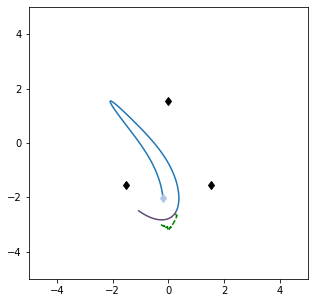

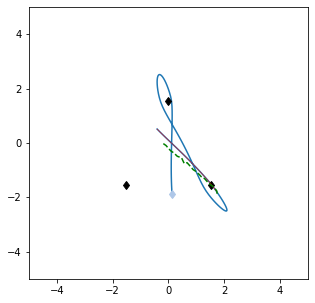

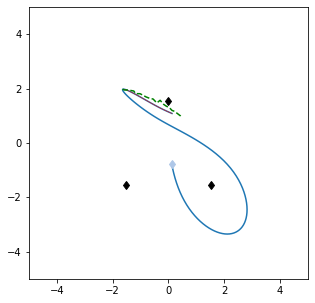

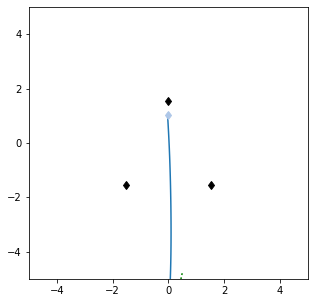

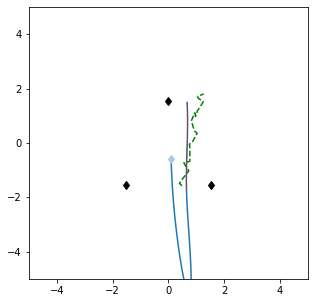

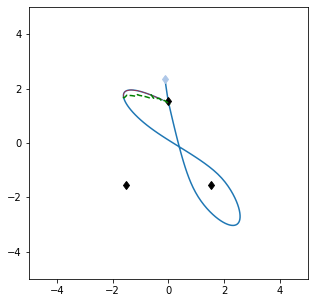

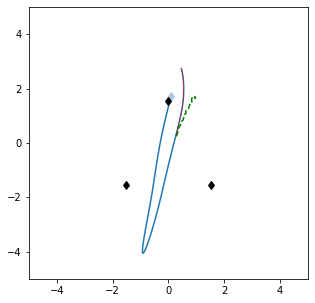

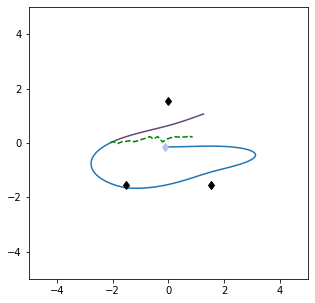

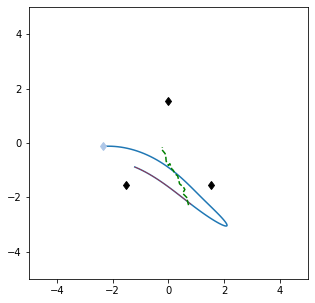

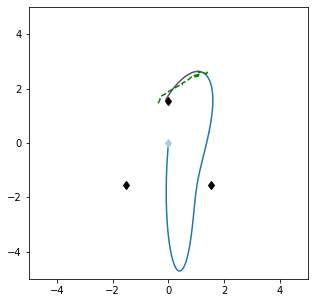

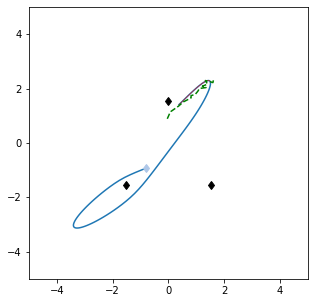

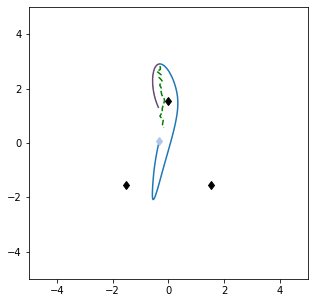

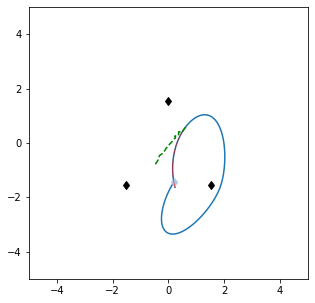

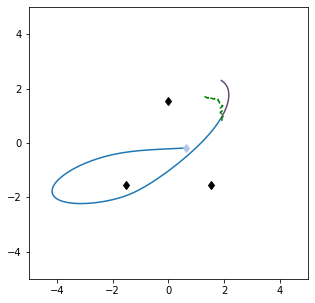

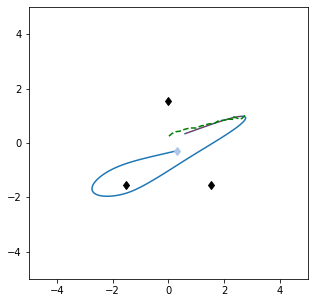

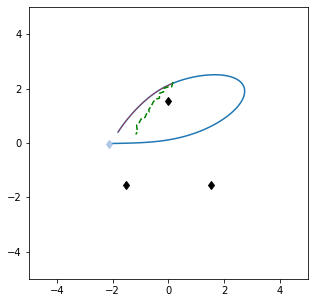

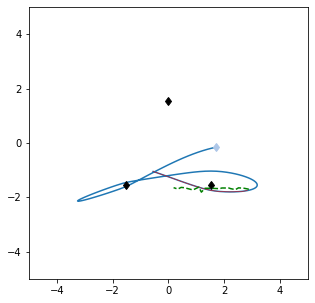

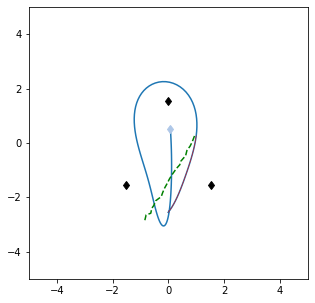

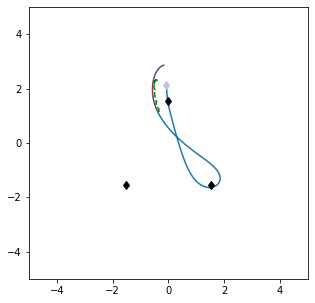

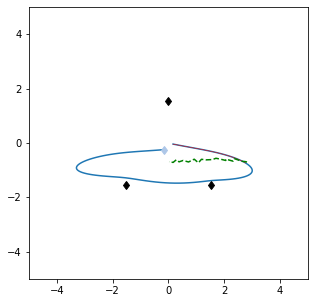

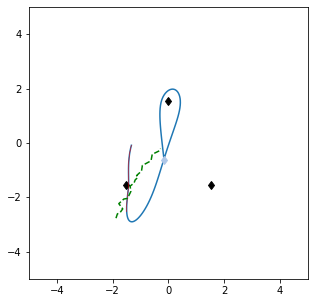

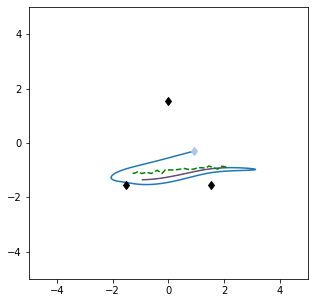

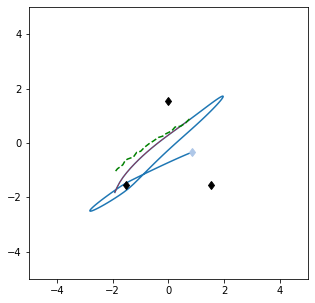

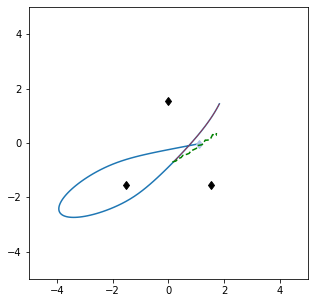

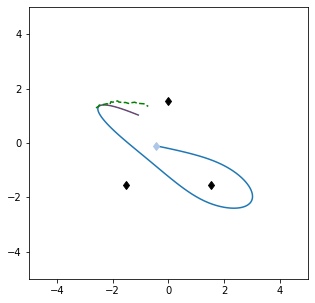

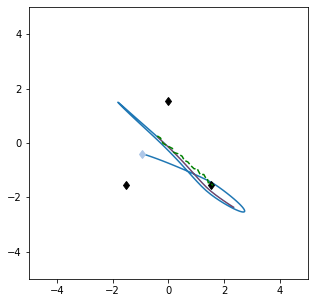

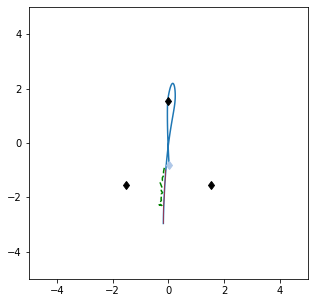

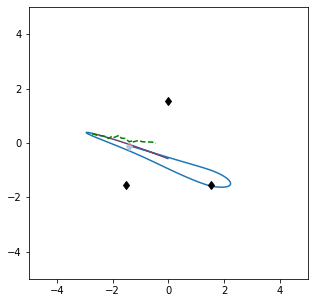

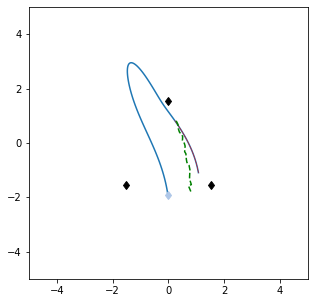

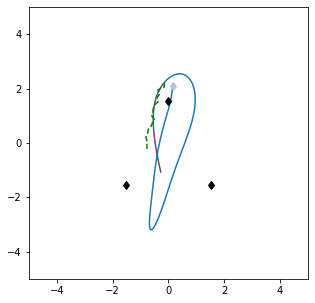

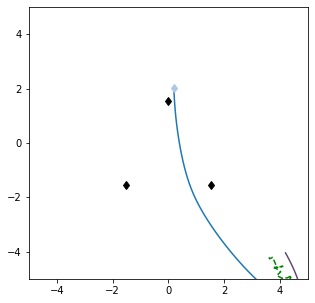

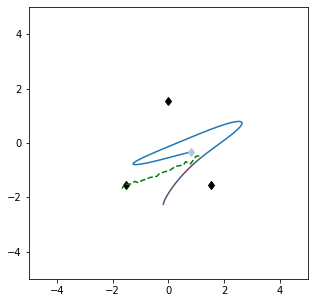

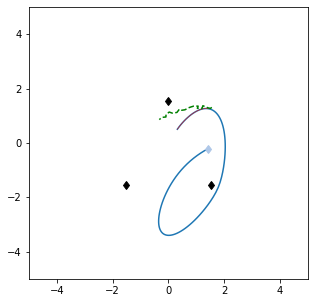

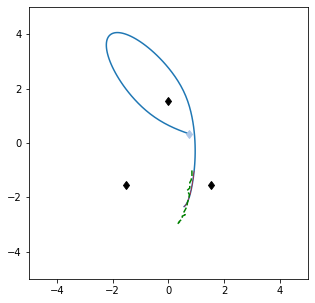

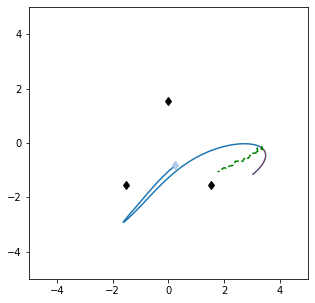

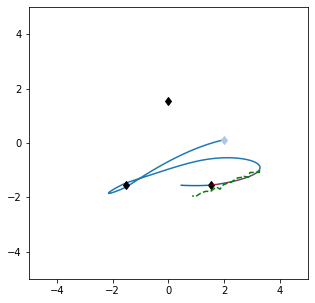

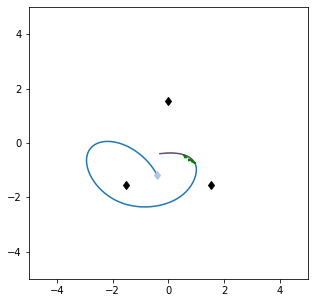

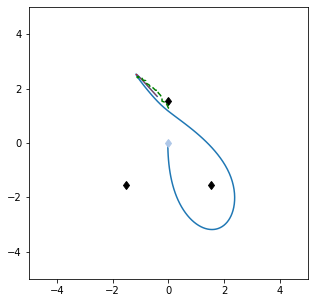

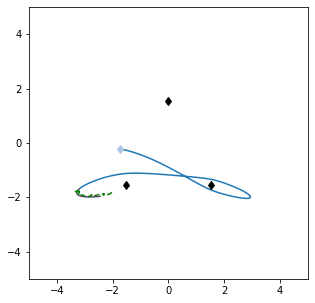

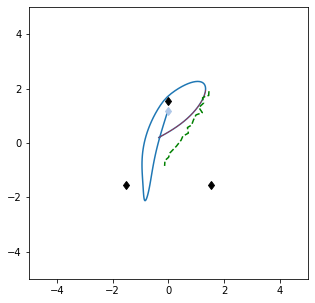

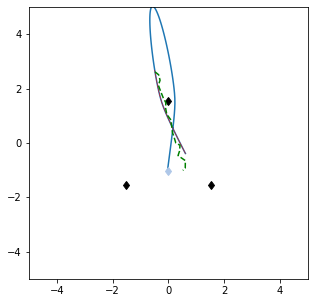

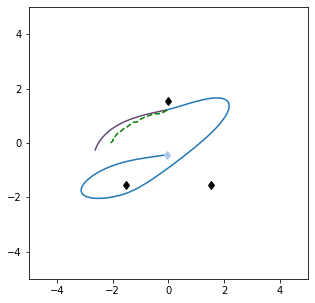

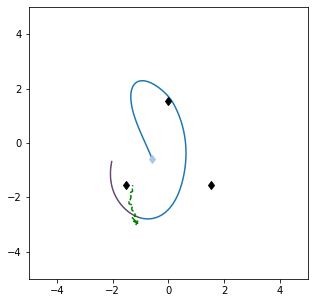

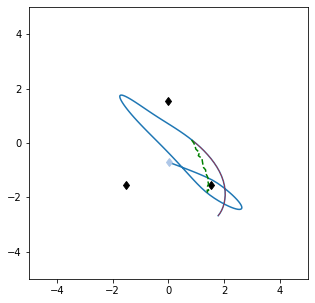

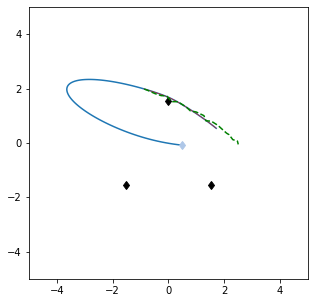

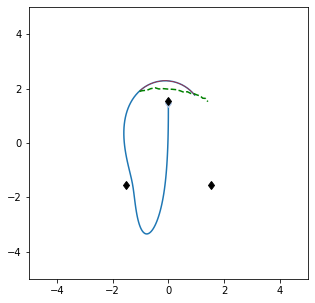

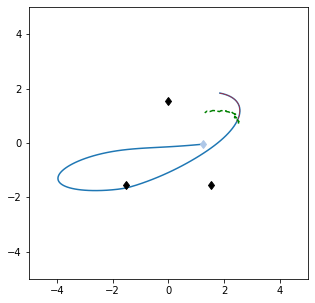

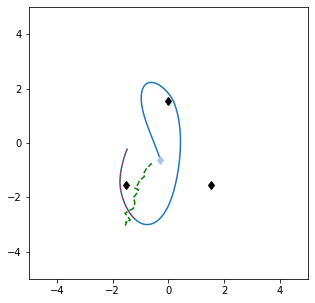

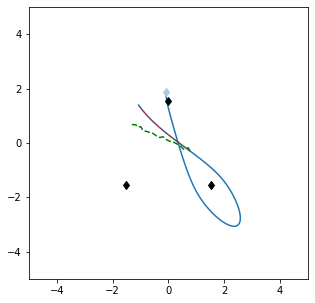

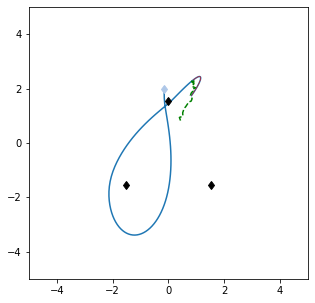

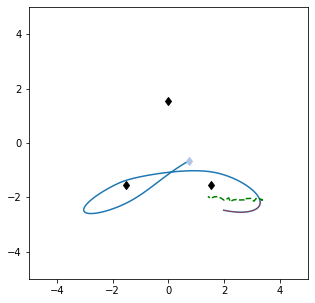

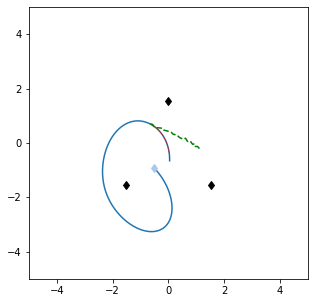

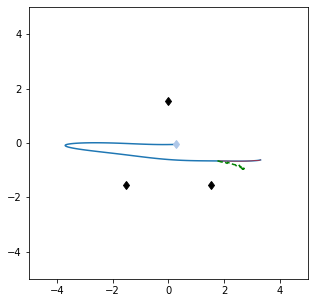

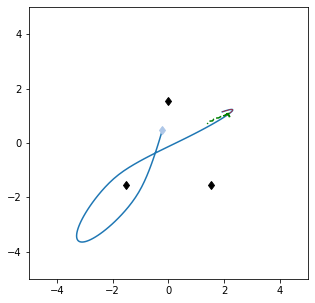

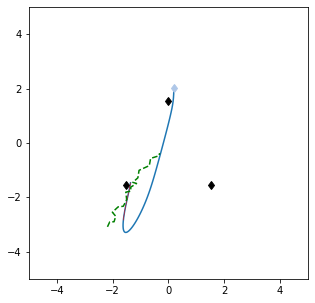

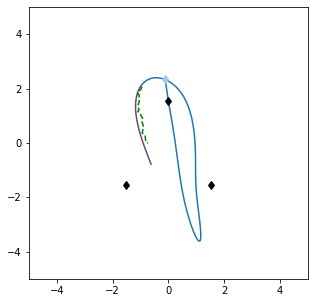

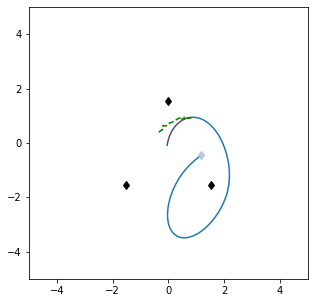

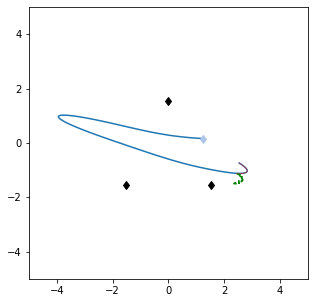

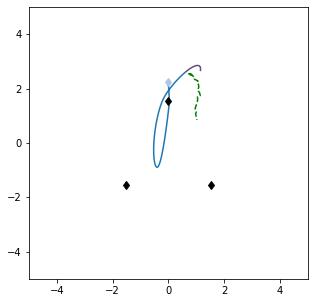

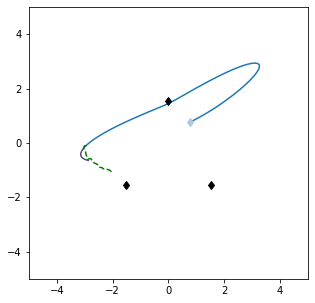

In [539]:
for i in range(len(dataset_test_path)):
    if not is_simulation_close_enough(model32, dataset_test_path, i):
        show_progress(dataset_test_path, model32, i)